In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import time
import logging
import itertools
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
dist = np.load('./distribution.npy')

In [3]:
def sample2d(dist, n):
    dist_flat = dist.reshape([-1])
    x1_max, x2_max = dist.shape
    raw_samples = np.random.choice(np.arange(0, x1_max * x2_max), size=[n], p=dist_flat)
    samples = [[s // x2_max, s % x2_max] for s in raw_samples]
    return np.array(samples)

samples = sample2d(dist, 100000)
X_train = torch.Tensor(samples[:60000 ]).int().cuda()
X_val = torch.Tensor(samples[60000:80000]).int().cuda()
X_test = torch.Tensor(samples[80000:]).int().cuda()

<IPython.core.display.Javascript object>


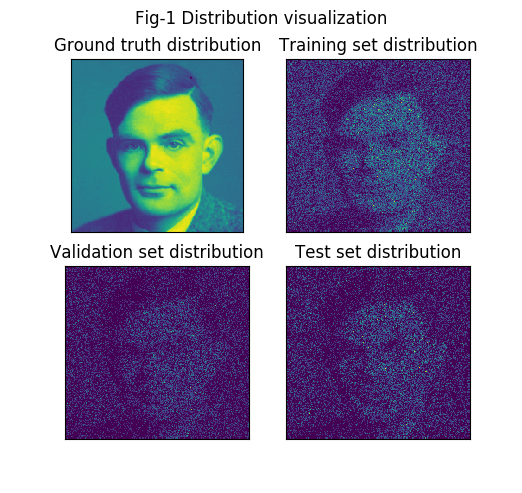

Text(0.5, 0.98, 'Fig-1 Distribution visualization')

In [10]:
# plot the sampled distribution of the three sets
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(dist)
axes[0, 0].set_title("Ground truth distribution")
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

X_train_np = X_train.data.cpu().numpy()
axes[0, 1].hist2d(X_train_np[:, 1], X_train_np[:, 0], bins=[200, 200])
axes[0, 1].invert_yaxis()
axes[0, 1].set_title("Training set distribution")
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

X_val_np = X_val.data.cpu().numpy()
axes[1, 0].hist2d(X_val_np[:, 1], X_val_np[:, 0], bins=[200, 200])
axes[1, 0].invert_yaxis()
axes[1, 0].set_title("Validation set distribution")
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

X_test_np = X_test.data.cpu().numpy()
axes[1, 1].hist2d(X_test_np[:, 1], X_test_np[:, 0], bins=[200, 200])
axes[1, 1].invert_yaxis()
axes[1, 1].set_title("Test set distribution")
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

fig.suptitle("Fig-1 Distribution visualization")

In [5]:
class MaskedLinear(nn.Linear):
    
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias=bias)
        self.register_buffer('mask', torch.ones([out_features, in_features]).double())
        self.reset_parameters()

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)
    
    def set_mask(self, mask):
        self.mask.data = mask.data
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)

In [6]:
class MADE(nn.Module):
    
    def __init__(self, d=2, n_classes=200, hidden_size=200, n_hidden_layers=1):
        super(MADE, self).__init__()
        
        self.d = d
        self.n_classes = n_classes
        self.input_size = d * n_classes
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        
        self.layers = nn.ModuleList()
        self.layers.append(MaskedLinear(self.input_size, hidden_size))
        for i in range(n_hidden_layers - 1):
            self.layers.append(MaskedLinear(hidden_size, hidden_size))
        self.outlayer = MaskedLinear(hidden_size, self.input_size) # times 200 for the range 
        
        # sampling m^l vectors
        self.m = []
        m_0 = []
        for i in range(d):
            m_0.extend([i + 1] * n_classes)
            
        self.m.append(torch.from_numpy(np.array(m_0)).requires_grad_(False)) # requires_grad is redundant?
        for i in range(n_hidden_layers):
            self.m.append(torch.randint(torch.min(self.m[-1]), d, [hidden_size]).requires_grad_(False))
        
        # construct masks
        for i in np.arange(1, n_hidden_layers + 1):
            mask = (self.m[i].view(-1, 1) >= self.m[i - 1].view(1, -1)).float()
            self.layers[i - 1].set_mask(mask)
            
        output_mask = (self.m[0].view(-1, 1).float() > self.m[-1].view(1, -1).float()).float()
        self.outlayer.set_mask(output_mask)
        
    def forward(self, x):
        out = x
        for mlinear in self.layers:
            out = mlinear(out)
            out = F.relu(out)
        out = self.outlayer(out)
        out = out.view(-1, self.d, self.n_classes)
        out = F.softmax(out, dim=2)
        return out
    
    def get_distribution(self):
        x = []
        for i in range(self.d):
            x.append(np.array(np.arange(0, self.n_classes)).reshape([self.n_classes]))
        x_long = torch.from_numpy(np.array(list(itertools.product(*x)))).long().cuda()
        x = one_hot_cat(x_long)
        p = net(x)
        batch_size = x.shape[0]
        p = torch.gather(p, 2, x_long.view([batch_size, self.d, 1])).view(batch_size, 2)
        p = p.cpu().data.numpy()
        ans = np.ones([p.shape[0]])
        for i in range(p.shape[1]):
            ans = ans * p[:, i]
        return ans.reshape([self.n_classes] * self.d)
    
    
def save_checkpoint(state, save_dir, ckpt_name='best.pth.tar'):
    file_path = os.path.join(save_dir, ckpt_name)
    if not os.path.exists(save_dir):
        print("Save directory dosen't exist! Makind directory {}".format(save_dir))
        os.mkdir(save_dir)
    
    torch.save(state, file_path)
    
    
def load_checkpoint(checkpoint, model):
    if not os.path.exists(checkpoint):
        raise Exception("File {} dosen't exists!".foramt(checkpoint))
    checkpoint = torch.load(checkpoint)
    saved_dict = checkpoint['state_dict']
    new_dict = model.state_dict()
    new_dict.update(saved_dict)
    model.load_state_dict(new_dict)
    
    
def set_logger(file_path):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if not logger.handlers:
        file_handler = logging.FileHandler(file_path)
        file_handler.setFormatter(logging.Formatter("%(asctime)s:%(levelname)s:%(message)s"))
        logger.addHandler(file_handler)

        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(logging.Formatter("%(asctime)s:%(message)s"))
        logger.addHandler(stream_handler)
        

def one_hot(x, n_classes=200):
    return torch.zeros(x.shape[0], n_classes).cuda().scatter_(1, x.long().view(-1, 1), 1)


def one_hot_cat(x, n_classes=200):
    l = []
    for i in range(x.shape[1]):
        l.append(one_hot(x[:, i], n_classes))
    return torch.cat(l, dim=1)


def plot_tensor(x):
    plt.figure()
    plt.imshow(x.cpu().data.numpy())
    

def get_mean_NLL(prob, observation):
    batch_size = prob.shape[0]
    logits = -torch.log(torch.gather(prob, 2, observation.view([batch_size, -1, 1])).view(batch_size, 2))
    mean_nll = torch.sum(logits) / batch_size
    return mean_nll

In [7]:
lr = 1e-3
best_nll = np.inf
save_dir = './checkpoints/MADE'
train_log = []
val_log = []

n_epochs = 500
batch_size = 5000
n_iter_per_epoch = X_train.shape[0] // batch_size

net = MADE(2, 200, 200, n_hidden_layers=1).cuda()
optimizer = optim.Adam(net.parameters(), lr=lr)

x_val_long = X_val.cuda().long()
x_val = one_hot_cat(x_val_long) 

set_logger('./train.log')

for i in range(n_epochs):
    idx = torch.randperm(X_train.shape[0])
    for j in range(n_iter_per_epoch):
        x_train_long = X_train[idx[j * batch_size: (j + 1) * batch_size]].long()
        x_train = one_hot_cat(x_train_long)
        p_train = net(x_train)
        
        loss = get_mean_NLL(p_train, x_train_long)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        p_val = net(x_val)
        nll_val = get_mean_NLL(p_val, x_val_long).detach() / (2 * np.log(2.0))
        nll_train = loss.clone().detach() / (2 * np.log(2.0))
        
        train_log.append(nll_train.item())
        val_log.append(nll_val.item())

        logging.info("Epoch-{:d}/{:d} Iter-{:d}/{:d} loss: {:.4f}, train_nll: {:.3f}, val_nll: {:.3f}"
                     .format(i + 1, n_epochs, j + 1, n_iter_per_epoch, loss.item(), nll_train.item(), nll_val.item()))
        
        if best_nll > nll_val:
            best_nll = nll_val 
            save_checkpoint({'epoch': i, 'state_dict': net.state_dict()}, save_dir, ckpt_name='best.pth.tar')
            
save_checkpoint({'epoch': i, 'state_dict': net.state_dict()}, save_dir, ckpt_name='last.pth.tar')

2019-07-03 13:37:51,026:Epoch-1/500 Iter-1/12 loss: 10.6003, train_nll: 7.646, val_nll: 7.645
2019-07-03 13:37:51,035:Epoch-1/500 Iter-2/12 loss: 10.5972, train_nll: 7.644, val_nll: 7.644
2019-07-03 13:37:51,049:Epoch-1/500 Iter-3/12 loss: 10.5967, train_nll: 7.644, val_nll: 7.643
2019-07-03 13:37:51,113:Epoch-1/500 Iter-4/12 loss: 10.5966, train_nll: 7.644, val_nll: 7.642
2019-07-03 13:37:51,151:Epoch-1/500 Iter-5/12 loss: 10.5935, train_nll: 7.642, val_nll: 7.641
2019-07-03 13:37:51,160:Epoch-1/500 Iter-6/12 loss: 10.5936, train_nll: 7.642, val_nll: 7.641
2019-07-03 13:37:51,168:Epoch-1/500 Iter-7/12 loss: 10.5936, train_nll: 7.642, val_nll: 7.640
2019-07-03 13:37:51,176:Epoch-1/500 Iter-8/12 loss: 10.5909, train_nll: 7.640, val_nll: 7.639
2019-07-03 13:37:51,195:Epoch-1/500 Iter-9/12 loss: 10.5904, train_nll: 7.639, val_nll: 7.638
2019-07-03 13:37:51,204:Epoch-1/500 Iter-10/12 loss: 10.5885, train_nll: 7.638, val_nll: 7.638
2019-07-03 13:37:51,212:Epoch-1/500 Iter-11/12 loss: 10.588

2019-07-03 13:37:52,009:Epoch-8/500 Iter-4/12 loss: 10.5324, train_nll: 7.598, val_nll: 7.616
2019-07-03 13:37:52,017:Epoch-8/500 Iter-5/12 loss: 10.5347, train_nll: 7.599, val_nll: 7.616
2019-07-03 13:37:52,026:Epoch-8/500 Iter-6/12 loss: 10.5309, train_nll: 7.596, val_nll: 7.616
2019-07-03 13:37:52,035:Epoch-8/500 Iter-7/12 loss: 10.5313, train_nll: 7.597, val_nll: 7.616
2019-07-03 13:37:52,043:Epoch-8/500 Iter-8/12 loss: 10.5324, train_nll: 7.598, val_nll: 7.616
2019-07-03 13:37:52,052:Epoch-8/500 Iter-9/12 loss: 10.5277, train_nll: 7.594, val_nll: 7.616
2019-07-03 13:37:52,061:Epoch-8/500 Iter-10/12 loss: 10.5347, train_nll: 7.599, val_nll: 7.615
2019-07-03 13:37:52,070:Epoch-8/500 Iter-11/12 loss: 10.5352, train_nll: 7.600, val_nll: 7.615
2019-07-03 13:37:52,078:Epoch-8/500 Iter-12/12 loss: 10.5292, train_nll: 7.595, val_nll: 7.615
2019-07-03 13:37:52,092:Epoch-9/500 Iter-1/12 loss: 10.5163, train_nll: 7.586, val_nll: 7.615
2019-07-03 13:37:52,101:Epoch-9/500 Iter-2/12 loss: 10.53

2019-07-03 13:37:56,324:Epoch-15/500 Iter-7/12 loss: 10.4895, train_nll: 7.567, val_nll: 7.613
2019-07-03 13:37:56,332:Epoch-15/500 Iter-8/12 loss: 10.4954, train_nll: 7.571, val_nll: 7.613
2019-07-03 13:37:56,339:Epoch-15/500 Iter-9/12 loss: 10.4894, train_nll: 7.567, val_nll: 7.613
2019-07-03 13:37:56,346:Epoch-15/500 Iter-10/12 loss: 10.4963, train_nll: 7.571, val_nll: 7.613
2019-07-03 13:37:56,356:Epoch-15/500 Iter-11/12 loss: 10.4940, train_nll: 7.570, val_nll: 7.613
2019-07-03 13:37:56,365:Epoch-15/500 Iter-12/12 loss: 10.4969, train_nll: 7.572, val_nll: 7.613
2019-07-03 13:37:56,376:Epoch-16/500 Iter-1/12 loss: 10.4922, train_nll: 7.568, val_nll: 7.613
2019-07-03 13:37:56,386:Epoch-16/500 Iter-2/12 loss: 10.4800, train_nll: 7.560, val_nll: 7.613
2019-07-03 13:37:56,393:Epoch-16/500 Iter-3/12 loss: 10.4873, train_nll: 7.565, val_nll: 7.613
2019-07-03 13:37:56,400:Epoch-16/500 Iter-4/12 loss: 10.4917, train_nll: 7.568, val_nll: 7.613
2019-07-03 13:37:56,407:Epoch-16/500 Iter-5/12 

2019-07-03 13:37:56,892:Epoch-22/500 Iter-10/12 loss: 10.4474, train_nll: 7.536, val_nll: 7.616
2019-07-03 13:37:56,897:Epoch-22/500 Iter-11/12 loss: 10.4438, train_nll: 7.534, val_nll: 7.616
2019-07-03 13:37:56,905:Epoch-22/500 Iter-12/12 loss: 10.4406, train_nll: 7.531, val_nll: 7.616
2019-07-03 13:37:56,912:Epoch-23/500 Iter-1/12 loss: 10.4343, train_nll: 7.527, val_nll: 7.616
2019-07-03 13:37:56,917:Epoch-23/500 Iter-2/12 loss: 10.4380, train_nll: 7.529, val_nll: 7.616
2019-07-03 13:37:56,923:Epoch-23/500 Iter-3/12 loss: 10.4509, train_nll: 7.539, val_nll: 7.616
2019-07-03 13:37:56,929:Epoch-23/500 Iter-4/12 loss: 10.4392, train_nll: 7.530, val_nll: 7.616
2019-07-03 13:37:56,934:Epoch-23/500 Iter-5/12 loss: 10.4422, train_nll: 7.532, val_nll: 7.616
2019-07-03 13:37:56,940:Epoch-23/500 Iter-6/12 loss: 10.4432, train_nll: 7.533, val_nll: 7.616
2019-07-03 13:37:56,946:Epoch-23/500 Iter-7/12 loss: 10.4461, train_nll: 7.535, val_nll: 7.616
2019-07-03 13:37:56,951:Epoch-23/500 Iter-8/12 

2019-07-03 13:37:57,397:Epoch-29/500 Iter-12/12 loss: 10.3980, train_nll: 7.501, val_nll: 7.627
2019-07-03 13:37:57,404:Epoch-30/500 Iter-1/12 loss: 10.3933, train_nll: 7.497, val_nll: 7.627
2019-07-03 13:37:57,409:Epoch-30/500 Iter-2/12 loss: 10.3875, train_nll: 7.493, val_nll: 7.627
2019-07-03 13:37:57,415:Epoch-30/500 Iter-3/12 loss: 10.3881, train_nll: 7.493, val_nll: 7.627
2019-07-03 13:37:57,421:Epoch-30/500 Iter-4/12 loss: 10.3941, train_nll: 7.498, val_nll: 7.627
2019-07-03 13:37:57,427:Epoch-30/500 Iter-5/12 loss: 10.3915, train_nll: 7.496, val_nll: 7.627
2019-07-03 13:37:57,432:Epoch-30/500 Iter-6/12 loss: 10.3879, train_nll: 7.493, val_nll: 7.627
2019-07-03 13:37:57,438:Epoch-30/500 Iter-7/12 loss: 10.3765, train_nll: 7.485, val_nll: 7.628
2019-07-03 13:37:57,444:Epoch-30/500 Iter-8/12 loss: 10.3907, train_nll: 7.495, val_nll: 7.628
2019-07-03 13:37:57,450:Epoch-30/500 Iter-9/12 loss: 10.3888, train_nll: 7.494, val_nll: 7.628
2019-07-03 13:37:57,455:Epoch-30/500 Iter-10/12 l

2019-07-03 13:37:57,909:Epoch-37/500 Iter-3/12 loss: 10.3475, train_nll: 7.464, val_nll: 7.644
2019-07-03 13:37:57,915:Epoch-37/500 Iter-4/12 loss: 10.3425, train_nll: 7.461, val_nll: 7.645
2019-07-03 13:37:57,921:Epoch-37/500 Iter-5/12 loss: 10.3454, train_nll: 7.463, val_nll: 7.645
2019-07-03 13:37:57,927:Epoch-37/500 Iter-6/12 loss: 10.3435, train_nll: 7.461, val_nll: 7.645
2019-07-03 13:37:57,934:Epoch-37/500 Iter-7/12 loss: 10.3476, train_nll: 7.464, val_nll: 7.646
2019-07-03 13:37:57,940:Epoch-37/500 Iter-8/12 loss: 10.3486, train_nll: 7.465, val_nll: 7.646
2019-07-03 13:37:57,946:Epoch-37/500 Iter-9/12 loss: 10.3506, train_nll: 7.466, val_nll: 7.646
2019-07-03 13:37:57,952:Epoch-37/500 Iter-10/12 loss: 10.3583, train_nll: 7.472, val_nll: 7.646
2019-07-03 13:37:57,958:Epoch-37/500 Iter-11/12 loss: 10.3505, train_nll: 7.466, val_nll: 7.647
2019-07-03 13:37:57,964:Epoch-37/500 Iter-12/12 loss: 10.3488, train_nll: 7.465, val_nll: 7.647
2019-07-03 13:37:57,971:Epoch-38/500 Iter-1/12 

2019-07-03 13:37:58,599:Epoch-44/500 Iter-6/12 loss: 10.3284, train_nll: 7.450, val_nll: 7.665
2019-07-03 13:37:58,604:Epoch-44/500 Iter-7/12 loss: 10.3317, train_nll: 7.453, val_nll: 7.665
2019-07-03 13:37:58,621:Epoch-44/500 Iter-8/12 loss: 10.3215, train_nll: 7.445, val_nll: 7.665
2019-07-03 13:37:58,645:Epoch-44/500 Iter-9/12 loss: 10.3096, train_nll: 7.437, val_nll: 7.665
2019-07-03 13:37:58,671:Epoch-44/500 Iter-10/12 loss: 10.3235, train_nll: 7.447, val_nll: 7.666
2019-07-03 13:37:58,700:Epoch-44/500 Iter-11/12 loss: 10.3283, train_nll: 7.450, val_nll: 7.666
2019-07-03 13:37:58,728:Epoch-44/500 Iter-12/12 loss: 10.3243, train_nll: 7.447, val_nll: 7.666
2019-07-03 13:37:58,755:Epoch-45/500 Iter-1/12 loss: 10.3091, train_nll: 7.436, val_nll: 7.666
2019-07-03 13:37:58,790:Epoch-45/500 Iter-2/12 loss: 10.3227, train_nll: 7.446, val_nll: 7.666
2019-07-03 13:37:58,809:Epoch-45/500 Iter-3/12 loss: 10.3119, train_nll: 7.438, val_nll: 7.666
2019-07-03 13:37:58,814:Epoch-45/500 Iter-4/12 

2019-07-03 13:37:59,731:Epoch-51/500 Iter-9/12 loss: 10.3137, train_nll: 7.440, val_nll: 7.683
2019-07-03 13:37:59,756:Epoch-51/500 Iter-10/12 loss: 10.3047, train_nll: 7.433, val_nll: 7.683
2019-07-03 13:37:59,763:Epoch-51/500 Iter-11/12 loss: 10.2967, train_nll: 7.428, val_nll: 7.683
2019-07-03 13:37:59,768:Epoch-51/500 Iter-12/12 loss: 10.3071, train_nll: 7.435, val_nll: 7.683
2019-07-03 13:37:59,775:Epoch-52/500 Iter-1/12 loss: 10.3001, train_nll: 7.430, val_nll: 7.684
2019-07-03 13:37:59,787:Epoch-52/500 Iter-2/12 loss: 10.2868, train_nll: 7.420, val_nll: 7.684
2019-07-03 13:37:59,792:Epoch-52/500 Iter-3/12 loss: 10.2804, train_nll: 7.416, val_nll: 7.684
2019-07-03 13:37:59,798:Epoch-52/500 Iter-4/12 loss: 10.2983, train_nll: 7.429, val_nll: 7.684
2019-07-03 13:37:59,804:Epoch-52/500 Iter-5/12 loss: 10.2818, train_nll: 7.417, val_nll: 7.684
2019-07-03 13:37:59,810:Epoch-52/500 Iter-6/12 loss: 10.2913, train_nll: 7.424, val_nll: 7.685
2019-07-03 13:37:59,816:Epoch-52/500 Iter-7/12 

2019-07-03 13:38:00,738:Epoch-58/500 Iter-12/12 loss: 10.2890, train_nll: 7.422, val_nll: 7.699
2019-07-03 13:38:00,745:Epoch-59/500 Iter-1/12 loss: 10.2798, train_nll: 7.415, val_nll: 7.699
2019-07-03 13:38:00,750:Epoch-59/500 Iter-2/12 loss: 10.2782, train_nll: 7.414, val_nll: 7.699
2019-07-03 13:38:00,756:Epoch-59/500 Iter-3/12 loss: 10.2828, train_nll: 7.417, val_nll: 7.700
2019-07-03 13:38:00,762:Epoch-59/500 Iter-4/12 loss: 10.2801, train_nll: 7.416, val_nll: 7.700
2019-07-03 13:38:00,768:Epoch-59/500 Iter-5/12 loss: 10.2869, train_nll: 7.420, val_nll: 7.700
2019-07-03 13:38:00,774:Epoch-59/500 Iter-6/12 loss: 10.2811, train_nll: 7.416, val_nll: 7.700
2019-07-03 13:38:00,780:Epoch-59/500 Iter-7/12 loss: 10.2564, train_nll: 7.398, val_nll: 7.701
2019-07-03 13:38:00,785:Epoch-59/500 Iter-8/12 loss: 10.2827, train_nll: 7.417, val_nll: 7.701
2019-07-03 13:38:00,793:Epoch-59/500 Iter-9/12 loss: 10.3058, train_nll: 7.434, val_nll: 7.701
2019-07-03 13:38:00,799:Epoch-59/500 Iter-10/12 l

2019-07-03 13:38:01,761:Epoch-66/500 Iter-3/12 loss: 10.2596, train_nll: 7.401, val_nll: 7.713
2019-07-03 13:38:01,787:Epoch-66/500 Iter-4/12 loss: 10.2501, train_nll: 7.394, val_nll: 7.713
2019-07-03 13:38:01,811:Epoch-66/500 Iter-5/12 loss: 10.2752, train_nll: 7.412, val_nll: 7.714
2019-07-03 13:38:01,838:Epoch-66/500 Iter-6/12 loss: 10.2676, train_nll: 7.407, val_nll: 7.714
2019-07-03 13:38:01,864:Epoch-66/500 Iter-7/12 loss: 10.2750, train_nll: 7.412, val_nll: 7.714
2019-07-03 13:38:01,896:Epoch-66/500 Iter-8/12 loss: 10.2703, train_nll: 7.408, val_nll: 7.715
2019-07-03 13:38:01,919:Epoch-66/500 Iter-9/12 loss: 10.2558, train_nll: 7.398, val_nll: 7.715
2019-07-03 13:38:01,925:Epoch-66/500 Iter-10/12 loss: 10.2766, train_nll: 7.413, val_nll: 7.715
2019-07-03 13:38:01,931:Epoch-66/500 Iter-11/12 loss: 10.2710, train_nll: 7.409, val_nll: 7.715
2019-07-03 13:38:01,937:Epoch-66/500 Iter-12/12 loss: 10.2787, train_nll: 7.414, val_nll: 7.715
2019-07-03 13:38:01,944:Epoch-67/500 Iter-1/12 

2019-07-03 13:38:02,853:Epoch-73/500 Iter-6/12 loss: 10.2480, train_nll: 7.392, val_nll: 7.726
2019-07-03 13:38:02,880:Epoch-73/500 Iter-7/12 loss: 10.2589, train_nll: 7.400, val_nll: 7.726
2019-07-03 13:38:02,888:Epoch-73/500 Iter-8/12 loss: 10.2556, train_nll: 7.398, val_nll: 7.726
2019-07-03 13:38:02,893:Epoch-73/500 Iter-9/12 loss: 10.2532, train_nll: 7.396, val_nll: 7.726
2019-07-03 13:38:02,899:Epoch-73/500 Iter-10/12 loss: 10.2540, train_nll: 7.397, val_nll: 7.726
2019-07-03 13:38:02,905:Epoch-73/500 Iter-11/12 loss: 10.2627, train_nll: 7.403, val_nll: 7.726
2019-07-03 13:38:02,911:Epoch-73/500 Iter-12/12 loss: 10.2724, train_nll: 7.410, val_nll: 7.726
2019-07-03 13:38:02,919:Epoch-74/500 Iter-1/12 loss: 10.2543, train_nll: 7.397, val_nll: 7.726
2019-07-03 13:38:02,925:Epoch-74/500 Iter-2/12 loss: 10.2538, train_nll: 7.397, val_nll: 7.727
2019-07-03 13:38:02,931:Epoch-74/500 Iter-3/12 loss: 10.2604, train_nll: 7.401, val_nll: 7.727
2019-07-03 13:38:02,937:Epoch-74/500 Iter-4/12 

2019-07-03 13:38:03,881:Epoch-80/500 Iter-9/12 loss: 10.2613, train_nll: 7.402, val_nll: 7.737
2019-07-03 13:38:03,887:Epoch-80/500 Iter-10/12 loss: 10.2460, train_nll: 7.391, val_nll: 7.737
2019-07-03 13:38:03,893:Epoch-80/500 Iter-11/12 loss: 10.2423, train_nll: 7.388, val_nll: 7.737
2019-07-03 13:38:03,899:Epoch-80/500 Iter-12/12 loss: 10.2583, train_nll: 7.400, val_nll: 7.737
2019-07-03 13:38:03,906:Epoch-81/500 Iter-1/12 loss: 10.2448, train_nll: 7.390, val_nll: 7.737
2019-07-03 13:38:03,912:Epoch-81/500 Iter-2/12 loss: 10.2462, train_nll: 7.391, val_nll: 7.737
2019-07-03 13:38:03,918:Epoch-81/500 Iter-3/12 loss: 10.2459, train_nll: 7.391, val_nll: 7.738
2019-07-03 13:38:03,925:Epoch-81/500 Iter-4/12 loss: 10.2424, train_nll: 7.388, val_nll: 7.738
2019-07-03 13:38:03,931:Epoch-81/500 Iter-5/12 loss: 10.2562, train_nll: 7.398, val_nll: 7.738
2019-07-03 13:38:03,937:Epoch-81/500 Iter-6/12 loss: 10.2310, train_nll: 7.380, val_nll: 7.739
2019-07-03 13:38:03,943:Epoch-81/500 Iter-7/12 

2019-07-03 13:38:04,861:Epoch-87/500 Iter-12/12 loss: 10.2382, train_nll: 7.385, val_nll: 7.747
2019-07-03 13:38:04,868:Epoch-88/500 Iter-1/12 loss: 10.2317, train_nll: 7.381, val_nll: 7.747
2019-07-03 13:38:04,873:Epoch-88/500 Iter-2/12 loss: 10.2303, train_nll: 7.380, val_nll: 7.747
2019-07-03 13:38:04,879:Epoch-88/500 Iter-3/12 loss: 10.2382, train_nll: 7.385, val_nll: 7.747
2019-07-03 13:38:04,885:Epoch-88/500 Iter-4/12 loss: 10.2321, train_nll: 7.381, val_nll: 7.748
2019-07-03 13:38:04,891:Epoch-88/500 Iter-5/12 loss: 10.2548, train_nll: 7.397, val_nll: 7.748
2019-07-03 13:38:04,905:Epoch-88/500 Iter-6/12 loss: 10.2422, train_nll: 7.388, val_nll: 7.748
2019-07-03 13:38:04,925:Epoch-88/500 Iter-7/12 loss: 10.2365, train_nll: 7.384, val_nll: 7.749
2019-07-03 13:38:04,951:Epoch-88/500 Iter-8/12 loss: 10.2304, train_nll: 7.380, val_nll: 7.749
2019-07-03 13:38:04,978:Epoch-88/500 Iter-9/12 loss: 10.2341, train_nll: 7.382, val_nll: 7.749
2019-07-03 13:38:05,003:Epoch-88/500 Iter-10/12 l

2019-07-03 13:38:05,853:Epoch-95/500 Iter-3/12 loss: 10.2369, train_nll: 7.384, val_nll: 7.756
2019-07-03 13:38:05,895:Epoch-95/500 Iter-4/12 loss: 10.2477, train_nll: 7.392, val_nll: 7.756
2019-07-03 13:38:05,924:Epoch-95/500 Iter-5/12 loss: 10.2257, train_nll: 7.376, val_nll: 7.756
2019-07-03 13:38:05,957:Epoch-95/500 Iter-6/12 loss: 10.2294, train_nll: 7.379, val_nll: 7.756
2019-07-03 13:38:05,982:Epoch-95/500 Iter-7/12 loss: 10.2293, train_nll: 7.379, val_nll: 7.757
2019-07-03 13:38:06,008:Epoch-95/500 Iter-8/12 loss: 10.2333, train_nll: 7.382, val_nll: 7.757
2019-07-03 13:38:06,037:Epoch-95/500 Iter-9/12 loss: 10.2318, train_nll: 7.381, val_nll: 7.757
2019-07-03 13:38:06,057:Epoch-95/500 Iter-10/12 loss: 10.2376, train_nll: 7.385, val_nll: 7.757
2019-07-03 13:38:06,062:Epoch-95/500 Iter-11/12 loss: 10.2216, train_nll: 7.373, val_nll: 7.757
2019-07-03 13:38:06,068:Epoch-95/500 Iter-12/12 loss: 10.2442, train_nll: 7.390, val_nll: 7.757
2019-07-03 13:38:06,075:Epoch-96/500 Iter-1/12 

2019-07-03 13:38:06,927:Epoch-102/500 Iter-5/12 loss: 10.2258, train_nll: 7.376, val_nll: 7.764
2019-07-03 13:38:06,949:Epoch-102/500 Iter-6/12 loss: 10.2306, train_nll: 7.380, val_nll: 7.765
2019-07-03 13:38:06,975:Epoch-102/500 Iter-7/12 loss: 10.2244, train_nll: 7.375, val_nll: 7.765
2019-07-03 13:38:06,998:Epoch-102/500 Iter-8/12 loss: 10.2231, train_nll: 7.374, val_nll: 7.765
2019-07-03 13:38:07,006:Epoch-102/500 Iter-9/12 loss: 10.2256, train_nll: 7.376, val_nll: 7.765
2019-07-03 13:38:07,013:Epoch-102/500 Iter-10/12 loss: 10.2278, train_nll: 7.378, val_nll: 7.765
2019-07-03 13:38:07,020:Epoch-102/500 Iter-11/12 loss: 10.2309, train_nll: 7.380, val_nll: 7.765
2019-07-03 13:38:07,028:Epoch-102/500 Iter-12/12 loss: 10.2508, train_nll: 7.394, val_nll: 7.765
2019-07-03 13:38:07,035:Epoch-103/500 Iter-1/12 loss: 10.2118, train_nll: 7.366, val_nll: 7.765
2019-07-03 13:38:07,041:Epoch-103/500 Iter-2/12 loss: 10.2238, train_nll: 7.375, val_nll: 7.765
2019-07-03 13:38:07,047:Epoch-103/500

2019-07-03 13:38:07,947:Epoch-109/500 Iter-7/12 loss: 10.2241, train_nll: 7.375, val_nll: 7.772
2019-07-03 13:38:07,953:Epoch-109/500 Iter-8/12 loss: 10.2300, train_nll: 7.379, val_nll: 7.772
2019-07-03 13:38:07,959:Epoch-109/500 Iter-9/12 loss: 10.2327, train_nll: 7.381, val_nll: 7.772
2019-07-03 13:38:07,966:Epoch-109/500 Iter-10/12 loss: 10.2178, train_nll: 7.371, val_nll: 7.772
2019-07-03 13:38:07,973:Epoch-109/500 Iter-11/12 loss: 10.2264, train_nll: 7.377, val_nll: 7.772
2019-07-03 13:38:07,980:Epoch-109/500 Iter-12/12 loss: 10.2221, train_nll: 7.374, val_nll: 7.772
2019-07-03 13:38:07,987:Epoch-110/500 Iter-1/12 loss: 10.2088, train_nll: 7.364, val_nll: 7.772
2019-07-03 13:38:07,994:Epoch-110/500 Iter-2/12 loss: 10.2118, train_nll: 7.366, val_nll: 7.772
2019-07-03 13:38:08,000:Epoch-110/500 Iter-3/12 loss: 10.2192, train_nll: 7.372, val_nll: 7.773
2019-07-03 13:38:08,006:Epoch-110/500 Iter-4/12 loss: 10.2287, train_nll: 7.378, val_nll: 7.773
2019-07-03 13:38:08,013:Epoch-110/500

2019-07-03 13:38:08,921:Epoch-116/500 Iter-9/12 loss: 10.2430, train_nll: 7.389, val_nll: 7.779
2019-07-03 13:38:08,928:Epoch-116/500 Iter-10/12 loss: 10.2156, train_nll: 7.369, val_nll: 7.779
2019-07-03 13:38:08,935:Epoch-116/500 Iter-11/12 loss: 10.2243, train_nll: 7.375, val_nll: 7.779
2019-07-03 13:38:08,942:Epoch-116/500 Iter-12/12 loss: 10.2269, train_nll: 7.377, val_nll: 7.779
2019-07-03 13:38:08,949:Epoch-117/500 Iter-1/12 loss: 10.2256, train_nll: 7.376, val_nll: 7.779
2019-07-03 13:38:08,956:Epoch-117/500 Iter-2/12 loss: 10.2212, train_nll: 7.373, val_nll: 7.779
2019-07-03 13:38:08,963:Epoch-117/500 Iter-3/12 loss: 10.2186, train_nll: 7.371, val_nll: 7.779
2019-07-03 13:38:08,969:Epoch-117/500 Iter-4/12 loss: 10.2095, train_nll: 7.365, val_nll: 7.779
2019-07-03 13:38:08,977:Epoch-117/500 Iter-5/12 loss: 10.2123, train_nll: 7.367, val_nll: 7.779
2019-07-03 13:38:08,993:Epoch-117/500 Iter-6/12 loss: 10.2177, train_nll: 7.370, val_nll: 7.780
2019-07-03 13:38:09,010:Epoch-117/500

2019-07-03 13:38:09,903:Epoch-123/500 Iter-11/12 loss: 10.2125, train_nll: 7.367, val_nll: 7.786
2019-07-03 13:38:09,909:Epoch-123/500 Iter-12/12 loss: 10.2258, train_nll: 7.376, val_nll: 7.786
2019-07-03 13:38:09,916:Epoch-124/500 Iter-1/12 loss: 10.2076, train_nll: 7.363, val_nll: 7.786
2019-07-03 13:38:09,940:Epoch-124/500 Iter-2/12 loss: 10.2097, train_nll: 7.365, val_nll: 7.786
2019-07-03 13:38:09,964:Epoch-124/500 Iter-3/12 loss: 10.2101, train_nll: 7.365, val_nll: 7.786
2019-07-03 13:38:09,986:Epoch-124/500 Iter-4/12 loss: 10.2012, train_nll: 7.359, val_nll: 7.786
2019-07-03 13:38:10,009:Epoch-124/500 Iter-5/12 loss: 10.2307, train_nll: 7.380, val_nll: 7.786
2019-07-03 13:38:10,035:Epoch-124/500 Iter-6/12 loss: 10.2331, train_nll: 7.382, val_nll: 7.787
2019-07-03 13:38:10,058:Epoch-124/500 Iter-7/12 loss: 10.2084, train_nll: 7.364, val_nll: 7.787
2019-07-03 13:38:10,083:Epoch-124/500 Iter-8/12 loss: 10.2109, train_nll: 7.366, val_nll: 7.787
2019-07-03 13:38:10,109:Epoch-124/500 

2019-07-03 13:38:10,901:Epoch-131/500 Iter-1/12 loss: 10.2122, train_nll: 7.367, val_nll: 7.792
2019-07-03 13:38:10,918:Epoch-131/500 Iter-2/12 loss: 10.2222, train_nll: 7.374, val_nll: 7.792
2019-07-03 13:38:10,930:Epoch-131/500 Iter-3/12 loss: 10.2087, train_nll: 7.364, val_nll: 7.792
2019-07-03 13:38:10,947:Epoch-131/500 Iter-4/12 loss: 10.2062, train_nll: 7.362, val_nll: 7.792
2019-07-03 13:38:10,962:Epoch-131/500 Iter-5/12 loss: 10.2183, train_nll: 7.371, val_nll: 7.792
2019-07-03 13:38:10,977:Epoch-131/500 Iter-6/12 loss: 10.2092, train_nll: 7.364, val_nll: 7.792
2019-07-03 13:38:10,993:Epoch-131/500 Iter-7/12 loss: 10.2091, train_nll: 7.364, val_nll: 7.792
2019-07-03 13:38:11,008:Epoch-131/500 Iter-8/12 loss: 10.1977, train_nll: 7.356, val_nll: 7.793
2019-07-03 13:38:11,031:Epoch-131/500 Iter-9/12 loss: 10.2310, train_nll: 7.380, val_nll: 7.793
2019-07-03 13:38:11,051:Epoch-131/500 Iter-10/12 loss: 10.2044, train_nll: 7.361, val_nll: 7.793
2019-07-03 13:38:11,071:Epoch-131/500 I

2019-07-03 13:38:11,893:Epoch-138/500 Iter-3/12 loss: 10.2026, train_nll: 7.360, val_nll: 7.798
2019-07-03 13:38:11,908:Epoch-138/500 Iter-4/12 loss: 10.2178, train_nll: 7.371, val_nll: 7.798
2019-07-03 13:38:11,925:Epoch-138/500 Iter-5/12 loss: 10.2153, train_nll: 7.369, val_nll: 7.798
2019-07-03 13:38:11,940:Epoch-138/500 Iter-6/12 loss: 10.2204, train_nll: 7.372, val_nll: 7.798
2019-07-03 13:38:11,959:Epoch-138/500 Iter-7/12 loss: 10.2168, train_nll: 7.370, val_nll: 7.798
2019-07-03 13:38:11,977:Epoch-138/500 Iter-8/12 loss: 10.1967, train_nll: 7.355, val_nll: 7.798
2019-07-03 13:38:11,999:Epoch-138/500 Iter-9/12 loss: 10.2034, train_nll: 7.360, val_nll: 7.798
2019-07-03 13:38:12,007:Epoch-138/500 Iter-10/12 loss: 10.2132, train_nll: 7.367, val_nll: 7.798
2019-07-03 13:38:12,014:Epoch-138/500 Iter-11/12 loss: 10.2062, train_nll: 7.362, val_nll: 7.798
2019-07-03 13:38:12,021:Epoch-138/500 Iter-12/12 loss: 10.2084, train_nll: 7.364, val_nll: 7.798
2019-07-03 13:38:12,027:Epoch-139/500

2019-07-03 13:38:12,767:Epoch-145/500 Iter-5/12 loss: 10.2000, train_nll: 7.358, val_nll: 7.803
2019-07-03 13:38:12,773:Epoch-145/500 Iter-6/12 loss: 10.1955, train_nll: 7.354, val_nll: 7.803
2019-07-03 13:38:12,779:Epoch-145/500 Iter-7/12 loss: 10.2196, train_nll: 7.372, val_nll: 7.803
2019-07-03 13:38:12,787:Epoch-145/500 Iter-8/12 loss: 10.2125, train_nll: 7.367, val_nll: 7.803
2019-07-03 13:38:12,802:Epoch-145/500 Iter-9/12 loss: 10.2055, train_nll: 7.362, val_nll: 7.803
2019-07-03 13:38:12,815:Epoch-145/500 Iter-10/12 loss: 10.2055, train_nll: 7.362, val_nll: 7.803
2019-07-03 13:38:12,830:Epoch-145/500 Iter-11/12 loss: 10.2079, train_nll: 7.363, val_nll: 7.803
2019-07-03 13:38:12,845:Epoch-145/500 Iter-12/12 loss: 10.2205, train_nll: 7.373, val_nll: 7.804
2019-07-03 13:38:12,861:Epoch-146/500 Iter-1/12 loss: 10.2075, train_nll: 7.363, val_nll: 7.804
2019-07-03 13:38:12,876:Epoch-146/500 Iter-2/12 loss: 10.2028, train_nll: 7.360, val_nll: 7.804
2019-07-03 13:38:12,891:Epoch-146/500

2019-07-03 13:38:13,734:Epoch-152/500 Iter-7/12 loss: 10.2032, train_nll: 7.360, val_nll: 7.808
2019-07-03 13:38:13,740:Epoch-152/500 Iter-8/12 loss: 10.2244, train_nll: 7.375, val_nll: 7.808
2019-07-03 13:38:13,745:Epoch-152/500 Iter-9/12 loss: 10.1951, train_nll: 7.354, val_nll: 7.808
2019-07-03 13:38:13,763:Epoch-152/500 Iter-10/12 loss: 10.1947, train_nll: 7.354, val_nll: 7.809
2019-07-03 13:38:13,785:Epoch-152/500 Iter-11/12 loss: 10.2131, train_nll: 7.367, val_nll: 7.809
2019-07-03 13:38:13,802:Epoch-152/500 Iter-12/12 loss: 10.2224, train_nll: 7.374, val_nll: 7.809
2019-07-03 13:38:13,820:Epoch-153/500 Iter-1/12 loss: 10.1934, train_nll: 7.353, val_nll: 7.809
2019-07-03 13:38:13,839:Epoch-153/500 Iter-2/12 loss: 10.2149, train_nll: 7.369, val_nll: 7.809
2019-07-03 13:38:13,856:Epoch-153/500 Iter-3/12 loss: 10.1969, train_nll: 7.355, val_nll: 7.809
2019-07-03 13:38:13,876:Epoch-153/500 Iter-4/12 loss: 10.2067, train_nll: 7.363, val_nll: 7.810
2019-07-03 13:38:13,898:Epoch-153/500

2019-07-03 13:38:14,658:Epoch-159/500 Iter-9/12 loss: 10.2072, train_nll: 7.363, val_nll: 7.815
2019-07-03 13:38:14,663:Epoch-159/500 Iter-10/12 loss: 10.1941, train_nll: 7.354, val_nll: 7.815
2019-07-03 13:38:14,669:Epoch-159/500 Iter-11/12 loss: 10.2043, train_nll: 7.361, val_nll: 7.815
2019-07-03 13:38:14,674:Epoch-159/500 Iter-12/12 loss: 10.2092, train_nll: 7.364, val_nll: 7.814
2019-07-03 13:38:14,681:Epoch-160/500 Iter-1/12 loss: 10.1887, train_nll: 7.350, val_nll: 7.814
2019-07-03 13:38:14,686:Epoch-160/500 Iter-2/12 loss: 10.1971, train_nll: 7.356, val_nll: 7.814
2019-07-03 13:38:14,692:Epoch-160/500 Iter-3/12 loss: 10.1954, train_nll: 7.354, val_nll: 7.814
2019-07-03 13:38:14,713:Epoch-160/500 Iter-4/12 loss: 10.2047, train_nll: 7.361, val_nll: 7.814
2019-07-03 13:38:14,735:Epoch-160/500 Iter-5/12 loss: 10.2103, train_nll: 7.365, val_nll: 7.814
2019-07-03 13:38:14,757:Epoch-160/500 Iter-6/12 loss: 10.1889, train_nll: 7.350, val_nll: 7.815
2019-07-03 13:38:14,780:Epoch-160/500

2019-07-03 13:38:15,793:Epoch-166/500 Iter-11/12 loss: 10.1969, train_nll: 7.355, val_nll: 7.819
2019-07-03 13:38:15,818:Epoch-166/500 Iter-12/12 loss: 10.2096, train_nll: 7.365, val_nll: 7.819
2019-07-03 13:38:15,825:Epoch-167/500 Iter-1/12 loss: 10.1900, train_nll: 7.351, val_nll: 7.819
2019-07-03 13:38:15,830:Epoch-167/500 Iter-2/12 loss: 10.2042, train_nll: 7.361, val_nll: 7.819
2019-07-03 13:38:15,836:Epoch-167/500 Iter-3/12 loss: 10.1979, train_nll: 7.356, val_nll: 7.819
2019-07-03 13:38:15,842:Epoch-167/500 Iter-4/12 loss: 10.1827, train_nll: 7.345, val_nll: 7.819
2019-07-03 13:38:15,847:Epoch-167/500 Iter-5/12 loss: 10.2004, train_nll: 7.358, val_nll: 7.819
2019-07-03 13:38:15,853:Epoch-167/500 Iter-6/12 loss: 10.1937, train_nll: 7.353, val_nll: 7.819
2019-07-03 13:38:15,858:Epoch-167/500 Iter-7/12 loss: 10.1898, train_nll: 7.350, val_nll: 7.819
2019-07-03 13:38:15,864:Epoch-167/500 Iter-8/12 loss: 10.2036, train_nll: 7.360, val_nll: 7.820
2019-07-03 13:38:15,869:Epoch-167/500 

2019-07-03 13:38:16,767:Epoch-174/500 Iter-1/12 loss: 10.1929, train_nll: 7.353, val_nll: 7.823
2019-07-03 13:38:16,773:Epoch-174/500 Iter-2/12 loss: 10.1921, train_nll: 7.352, val_nll: 7.823
2019-07-03 13:38:16,779:Epoch-174/500 Iter-3/12 loss: 10.1848, train_nll: 7.347, val_nll: 7.823
2019-07-03 13:38:16,785:Epoch-174/500 Iter-4/12 loss: 10.2008, train_nll: 7.358, val_nll: 7.824
2019-07-03 13:38:16,790:Epoch-174/500 Iter-5/12 loss: 10.1898, train_nll: 7.350, val_nll: 7.824
2019-07-03 13:38:16,796:Epoch-174/500 Iter-6/12 loss: 10.2121, train_nll: 7.366, val_nll: 7.824
2019-07-03 13:38:16,802:Epoch-174/500 Iter-7/12 loss: 10.2010, train_nll: 7.358, val_nll: 7.824
2019-07-03 13:38:16,820:Epoch-174/500 Iter-8/12 loss: 10.1960, train_nll: 7.355, val_nll: 7.824
2019-07-03 13:38:16,838:Epoch-174/500 Iter-9/12 loss: 10.1974, train_nll: 7.356, val_nll: 7.824
2019-07-03 13:38:16,858:Epoch-174/500 Iter-10/12 loss: 10.1948, train_nll: 7.354, val_nll: 7.824
2019-07-03 13:38:16,877:Epoch-174/500 I

2019-07-03 13:38:17,730:Epoch-181/500 Iter-3/12 loss: 10.1959, train_nll: 7.355, val_nll: 7.828
2019-07-03 13:38:17,736:Epoch-181/500 Iter-4/12 loss: 10.1974, train_nll: 7.356, val_nll: 7.828
2019-07-03 13:38:17,742:Epoch-181/500 Iter-5/12 loss: 10.1983, train_nll: 7.357, val_nll: 7.828
2019-07-03 13:38:17,749:Epoch-181/500 Iter-6/12 loss: 10.1781, train_nll: 7.342, val_nll: 7.829
2019-07-03 13:38:17,755:Epoch-181/500 Iter-7/12 loss: 10.1849, train_nll: 7.347, val_nll: 7.829
2019-07-03 13:38:17,761:Epoch-181/500 Iter-8/12 loss: 10.2025, train_nll: 7.360, val_nll: 7.829
2019-07-03 13:38:17,767:Epoch-181/500 Iter-9/12 loss: 10.2123, train_nll: 7.367, val_nll: 7.829
2019-07-03 13:38:17,773:Epoch-181/500 Iter-10/12 loss: 10.1898, train_nll: 7.350, val_nll: 7.829
2019-07-03 13:38:17,779:Epoch-181/500 Iter-11/12 loss: 10.2018, train_nll: 7.359, val_nll: 7.829
2019-07-03 13:38:17,785:Epoch-181/500 Iter-12/12 loss: 10.2087, train_nll: 7.364, val_nll: 7.829
2019-07-03 13:38:17,798:Epoch-182/500

2019-07-03 13:38:18,694:Epoch-188/500 Iter-5/12 loss: 10.1952, train_nll: 7.354, val_nll: 7.833
2019-07-03 13:38:18,709:Epoch-188/500 Iter-6/12 loss: 10.1961, train_nll: 7.355, val_nll: 7.833
2019-07-03 13:38:18,726:Epoch-188/500 Iter-7/12 loss: 10.1936, train_nll: 7.353, val_nll: 7.833
2019-07-03 13:38:18,748:Epoch-188/500 Iter-8/12 loss: 10.1930, train_nll: 7.353, val_nll: 7.834
2019-07-03 13:38:18,775:Epoch-188/500 Iter-9/12 loss: 10.1787, train_nll: 7.342, val_nll: 7.834
2019-07-03 13:38:18,798:Epoch-188/500 Iter-10/12 loss: 10.2100, train_nll: 7.365, val_nll: 7.834
2019-07-03 13:38:18,818:Epoch-188/500 Iter-11/12 loss: 10.2040, train_nll: 7.361, val_nll: 7.833
2019-07-03 13:38:18,842:Epoch-188/500 Iter-12/12 loss: 10.2066, train_nll: 7.363, val_nll: 7.833
2019-07-03 13:38:18,870:Epoch-189/500 Iter-1/12 loss: 10.1659, train_nll: 7.333, val_nll: 7.833
2019-07-03 13:38:18,887:Epoch-189/500 Iter-2/12 loss: 10.1936, train_nll: 7.353, val_nll: 7.833
2019-07-03 13:38:18,894:Epoch-189/500

2019-07-03 13:38:19,628:Epoch-195/500 Iter-7/12 loss: 10.1877, train_nll: 7.349, val_nll: 7.838
2019-07-03 13:38:19,644:Epoch-195/500 Iter-8/12 loss: 10.1983, train_nll: 7.357, val_nll: 7.838
2019-07-03 13:38:19,660:Epoch-195/500 Iter-9/12 loss: 10.1879, train_nll: 7.349, val_nll: 7.838
2019-07-03 13:38:19,677:Epoch-195/500 Iter-10/12 loss: 10.2020, train_nll: 7.359, val_nll: 7.838
2019-07-03 13:38:19,693:Epoch-195/500 Iter-11/12 loss: 10.2076, train_nll: 7.363, val_nll: 7.838
2019-07-03 13:38:19,711:Epoch-195/500 Iter-12/12 loss: 10.1904, train_nll: 7.351, val_nll: 7.837
2019-07-03 13:38:19,730:Epoch-196/500 Iter-1/12 loss: 10.2022, train_nll: 7.359, val_nll: 7.837
2019-07-03 13:38:19,748:Epoch-196/500 Iter-2/12 loss: 10.1835, train_nll: 7.346, val_nll: 7.837
2019-07-03 13:38:19,765:Epoch-196/500 Iter-3/12 loss: 10.1939, train_nll: 7.353, val_nll: 7.837
2019-07-03 13:38:19,785:Epoch-196/500 Iter-4/12 loss: 10.1921, train_nll: 7.352, val_nll: 7.838
2019-07-03 13:38:19,806:Epoch-196/500

2019-07-03 13:38:20,577:Epoch-202/500 Iter-9/12 loss: 10.1934, train_nll: 7.353, val_nll: 7.842
2019-07-03 13:38:20,602:Epoch-202/500 Iter-10/12 loss: 10.2024, train_nll: 7.359, val_nll: 7.842
2019-07-03 13:38:20,627:Epoch-202/500 Iter-11/12 loss: 10.2060, train_nll: 7.362, val_nll: 7.841
2019-07-03 13:38:20,650:Epoch-202/500 Iter-12/12 loss: 10.1971, train_nll: 7.356, val_nll: 7.841
2019-07-03 13:38:20,677:Epoch-203/500 Iter-1/12 loss: 10.1797, train_nll: 7.343, val_nll: 7.841
2019-07-03 13:38:20,697:Epoch-203/500 Iter-2/12 loss: 10.1955, train_nll: 7.354, val_nll: 7.841
2019-07-03 13:38:20,724:Epoch-203/500 Iter-3/12 loss: 10.1914, train_nll: 7.352, val_nll: 7.841
2019-07-03 13:38:20,747:Epoch-203/500 Iter-4/12 loss: 10.1781, train_nll: 7.342, val_nll: 7.841
2019-07-03 13:38:20,761:Epoch-203/500 Iter-5/12 loss: 10.1960, train_nll: 7.355, val_nll: 7.842
2019-07-03 13:38:20,769:Epoch-203/500 Iter-6/12 loss: 10.2029, train_nll: 7.360, val_nll: 7.842
2019-07-03 13:38:20,775:Epoch-203/500

2019-07-03 13:38:21,518:Epoch-209/500 Iter-11/12 loss: 10.1856, train_nll: 7.347, val_nll: 7.845
2019-07-03 13:38:21,524:Epoch-209/500 Iter-12/12 loss: 10.1970, train_nll: 7.356, val_nll: 7.845
2019-07-03 13:38:21,531:Epoch-210/500 Iter-1/12 loss: 10.1791, train_nll: 7.343, val_nll: 7.845
2019-07-03 13:38:21,537:Epoch-210/500 Iter-2/12 loss: 10.1915, train_nll: 7.352, val_nll: 7.845
2019-07-03 13:38:21,543:Epoch-210/500 Iter-3/12 loss: 10.1875, train_nll: 7.349, val_nll: 7.846
2019-07-03 13:38:21,550:Epoch-210/500 Iter-4/12 loss: 10.1674, train_nll: 7.334, val_nll: 7.846
2019-07-03 13:38:21,556:Epoch-210/500 Iter-5/12 loss: 10.2041, train_nll: 7.361, val_nll: 7.846
2019-07-03 13:38:21,562:Epoch-210/500 Iter-6/12 loss: 10.2000, train_nll: 7.358, val_nll: 7.846
2019-07-03 13:38:21,577:Epoch-210/500 Iter-7/12 loss: 10.1873, train_nll: 7.349, val_nll: 7.847
2019-07-03 13:38:21,593:Epoch-210/500 Iter-8/12 loss: 10.1857, train_nll: 7.347, val_nll: 7.847
2019-07-03 13:38:21,609:Epoch-210/500 

2019-07-03 13:38:22,441:Epoch-217/500 Iter-1/12 loss: 10.1839, train_nll: 7.346, val_nll: 7.849
2019-07-03 13:38:22,448:Epoch-217/500 Iter-2/12 loss: 10.1981, train_nll: 7.356, val_nll: 7.849
2019-07-03 13:38:22,455:Epoch-217/500 Iter-3/12 loss: 10.1743, train_nll: 7.339, val_nll: 7.849
2019-07-03 13:38:22,461:Epoch-217/500 Iter-4/12 loss: 10.1629, train_nll: 7.331, val_nll: 7.849
2019-07-03 13:38:22,467:Epoch-217/500 Iter-5/12 loss: 10.1859, train_nll: 7.348, val_nll: 7.849
2019-07-03 13:38:22,472:Epoch-217/500 Iter-6/12 loss: 10.1984, train_nll: 7.357, val_nll: 7.849
2019-07-03 13:38:22,478:Epoch-217/500 Iter-7/12 loss: 10.2063, train_nll: 7.362, val_nll: 7.850
2019-07-03 13:38:22,484:Epoch-217/500 Iter-8/12 loss: 10.1953, train_nll: 7.354, val_nll: 7.850
2019-07-03 13:38:22,489:Epoch-217/500 Iter-9/12 loss: 10.1796, train_nll: 7.343, val_nll: 7.850
2019-07-03 13:38:22,507:Epoch-217/500 Iter-10/12 loss: 10.1718, train_nll: 7.337, val_nll: 7.850
2019-07-03 13:38:22,525:Epoch-217/500 I

2019-07-03 13:38:23,410:Epoch-224/500 Iter-3/12 loss: 10.1781, train_nll: 7.342, val_nll: 7.853
2019-07-03 13:38:23,433:Epoch-224/500 Iter-4/12 loss: 10.1736, train_nll: 7.339, val_nll: 7.853
2019-07-03 13:38:23,460:Epoch-224/500 Iter-5/12 loss: 10.2018, train_nll: 7.359, val_nll: 7.853
2019-07-03 13:38:23,485:Epoch-224/500 Iter-6/12 loss: 10.1884, train_nll: 7.349, val_nll: 7.853
2019-07-03 13:38:23,512:Epoch-224/500 Iter-7/12 loss: 10.1875, train_nll: 7.349, val_nll: 7.853
2019-07-03 13:38:23,539:Epoch-224/500 Iter-8/12 loss: 10.2003, train_nll: 7.358, val_nll: 7.853
2019-07-03 13:38:23,566:Epoch-224/500 Iter-9/12 loss: 10.1690, train_nll: 7.335, val_nll: 7.853
2019-07-03 13:38:23,591:Epoch-224/500 Iter-10/12 loss: 10.1697, train_nll: 7.336, val_nll: 7.853
2019-07-03 13:38:23,612:Epoch-224/500 Iter-11/12 loss: 10.1935, train_nll: 7.353, val_nll: 7.853
2019-07-03 13:38:23,618:Epoch-224/500 Iter-12/12 loss: 10.2027, train_nll: 7.360, val_nll: 7.853
2019-07-03 13:38:23,625:Epoch-225/500

2019-07-03 13:38:24,327:Epoch-231/500 Iter-5/12 loss: 10.1776, train_nll: 7.342, val_nll: 7.857
2019-07-03 13:38:24,334:Epoch-231/500 Iter-6/12 loss: 10.1883, train_nll: 7.349, val_nll: 7.857
2019-07-03 13:38:24,341:Epoch-231/500 Iter-7/12 loss: 10.1782, train_nll: 7.342, val_nll: 7.857
2019-07-03 13:38:24,347:Epoch-231/500 Iter-8/12 loss: 10.1881, train_nll: 7.349, val_nll: 7.857
2019-07-03 13:38:24,352:Epoch-231/500 Iter-9/12 loss: 10.1894, train_nll: 7.350, val_nll: 7.857
2019-07-03 13:38:24,358:Epoch-231/500 Iter-10/12 loss: 10.1862, train_nll: 7.348, val_nll: 7.857
2019-07-03 13:38:24,364:Epoch-231/500 Iter-11/12 loss: 10.1998, train_nll: 7.358, val_nll: 7.857
2019-07-03 13:38:24,370:Epoch-231/500 Iter-12/12 loss: 10.2070, train_nll: 7.363, val_nll: 7.857
2019-07-03 13:38:24,377:Epoch-232/500 Iter-1/12 loss: 10.1648, train_nll: 7.332, val_nll: 7.857
2019-07-03 13:38:24,390:Epoch-232/500 Iter-2/12 loss: 10.1723, train_nll: 7.338, val_nll: 7.857
2019-07-03 13:38:24,403:Epoch-232/500

2019-07-03 13:38:25,233:Epoch-238/500 Iter-7/12 loss: 10.1917, train_nll: 7.352, val_nll: 7.861
2019-07-03 13:38:25,239:Epoch-238/500 Iter-8/12 loss: 10.1923, train_nll: 7.352, val_nll: 7.861
2019-07-03 13:38:25,245:Epoch-238/500 Iter-9/12 loss: 10.2029, train_nll: 7.360, val_nll: 7.861
2019-07-03 13:38:25,250:Epoch-238/500 Iter-10/12 loss: 10.1758, train_nll: 7.340, val_nll: 7.861
2019-07-03 13:38:25,256:Epoch-238/500 Iter-11/12 loss: 10.1816, train_nll: 7.344, val_nll: 7.861
2019-07-03 13:38:25,262:Epoch-238/500 Iter-12/12 loss: 10.1875, train_nll: 7.349, val_nll: 7.861
2019-07-03 13:38:25,269:Epoch-239/500 Iter-1/12 loss: 10.1698, train_nll: 7.336, val_nll: 7.861
2019-07-03 13:38:25,275:Epoch-239/500 Iter-2/12 loss: 10.1735, train_nll: 7.339, val_nll: 7.861
2019-07-03 13:38:25,281:Epoch-239/500 Iter-3/12 loss: 10.1784, train_nll: 7.342, val_nll: 7.861
2019-07-03 13:38:25,287:Epoch-239/500 Iter-4/12 loss: 10.1756, train_nll: 7.340, val_nll: 7.861
2019-07-03 13:38:25,311:Epoch-239/500

2019-07-03 13:38:26,180:Epoch-245/500 Iter-9/12 loss: 10.1867, train_nll: 7.348, val_nll: 7.864
2019-07-03 13:38:26,185:Epoch-245/500 Iter-10/12 loss: 10.1827, train_nll: 7.345, val_nll: 7.864
2019-07-03 13:38:26,191:Epoch-245/500 Iter-11/12 loss: 10.1762, train_nll: 7.341, val_nll: 7.864
2019-07-03 13:38:26,197:Epoch-245/500 Iter-12/12 loss: 10.1873, train_nll: 7.349, val_nll: 7.864
2019-07-03 13:38:26,205:Epoch-246/500 Iter-1/12 loss: 10.1757, train_nll: 7.340, val_nll: 7.864
2019-07-03 13:38:26,212:Epoch-246/500 Iter-2/12 loss: 10.1835, train_nll: 7.346, val_nll: 7.864
2019-07-03 13:38:26,217:Epoch-246/500 Iter-3/12 loss: 10.1730, train_nll: 7.338, val_nll: 7.864
2019-07-03 13:38:26,232:Epoch-246/500 Iter-4/12 loss: 10.1652, train_nll: 7.333, val_nll: 7.864
2019-07-03 13:38:26,247:Epoch-246/500 Iter-5/12 loss: 10.1890, train_nll: 7.350, val_nll: 7.864
2019-07-03 13:38:26,262:Epoch-246/500 Iter-6/12 loss: 10.1823, train_nll: 7.345, val_nll: 7.864
2019-07-03 13:38:26,278:Epoch-246/500

2019-07-03 13:38:27,159:Epoch-252/500 Iter-11/12 loss: 10.1981, train_nll: 7.356, val_nll: 7.868
2019-07-03 13:38:27,181:Epoch-252/500 Iter-12/12 loss: 10.1828, train_nll: 7.345, val_nll: 7.868
2019-07-03 13:38:27,205:Epoch-253/500 Iter-1/12 loss: 10.1886, train_nll: 7.350, val_nll: 7.868
2019-07-03 13:38:27,227:Epoch-253/500 Iter-2/12 loss: 10.1716, train_nll: 7.337, val_nll: 7.868
2019-07-03 13:38:27,249:Epoch-253/500 Iter-3/12 loss: 10.1622, train_nll: 7.330, val_nll: 7.868
2019-07-03 13:38:27,272:Epoch-253/500 Iter-4/12 loss: 10.1721, train_nll: 7.338, val_nll: 7.868
2019-07-03 13:38:27,295:Epoch-253/500 Iter-5/12 loss: 10.1865, train_nll: 7.348, val_nll: 7.868
2019-07-03 13:38:27,316:Epoch-253/500 Iter-6/12 loss: 10.1738, train_nll: 7.339, val_nll: 7.868
2019-07-03 13:38:27,327:Epoch-253/500 Iter-7/12 loss: 10.1806, train_nll: 7.344, val_nll: 7.868
2019-07-03 13:38:27,334:Epoch-253/500 Iter-8/12 loss: 10.1851, train_nll: 7.347, val_nll: 7.868
2019-07-03 13:38:27,341:Epoch-253/500 

2019-07-03 13:38:28,247:Epoch-260/500 Iter-1/12 loss: 10.1706, train_nll: 7.337, val_nll: 7.871
2019-07-03 13:38:28,254:Epoch-260/500 Iter-2/12 loss: 10.1841, train_nll: 7.346, val_nll: 7.871
2019-07-03 13:38:28,261:Epoch-260/500 Iter-3/12 loss: 10.1654, train_nll: 7.333, val_nll: 7.871
2019-07-03 13:38:28,269:Epoch-260/500 Iter-4/12 loss: 10.1836, train_nll: 7.346, val_nll: 7.871
2019-07-03 13:38:28,276:Epoch-260/500 Iter-5/12 loss: 10.1764, train_nll: 7.341, val_nll: 7.871
2019-07-03 13:38:28,283:Epoch-260/500 Iter-6/12 loss: 10.1902, train_nll: 7.351, val_nll: 7.871
2019-07-03 13:38:28,289:Epoch-260/500 Iter-7/12 loss: 10.1817, train_nll: 7.345, val_nll: 7.872
2019-07-03 13:38:28,295:Epoch-260/500 Iter-8/12 loss: 10.1810, train_nll: 7.344, val_nll: 7.872
2019-07-03 13:38:28,301:Epoch-260/500 Iter-9/12 loss: 10.1696, train_nll: 7.336, val_nll: 7.872
2019-07-03 13:38:28,307:Epoch-260/500 Iter-10/12 loss: 10.1811, train_nll: 7.344, val_nll: 7.872
2019-07-03 13:38:28,313:Epoch-260/500 I

2019-07-03 13:38:29,275:Epoch-267/500 Iter-3/12 loss: 10.1727, train_nll: 7.338, val_nll: 7.874
2019-07-03 13:38:29,298:Epoch-267/500 Iter-4/12 loss: 10.1774, train_nll: 7.341, val_nll: 7.875
2019-07-03 13:38:29,325:Epoch-267/500 Iter-5/12 loss: 10.1655, train_nll: 7.333, val_nll: 7.875
2019-07-03 13:38:29,350:Epoch-267/500 Iter-6/12 loss: 10.1808, train_nll: 7.344, val_nll: 7.875
2019-07-03 13:38:29,374:Epoch-267/500 Iter-7/12 loss: 10.1676, train_nll: 7.334, val_nll: 7.875
2019-07-03 13:38:29,400:Epoch-267/500 Iter-8/12 loss: 10.1706, train_nll: 7.337, val_nll: 7.875
2019-07-03 13:38:29,425:Epoch-267/500 Iter-9/12 loss: 10.1875, train_nll: 7.349, val_nll: 7.875
2019-07-03 13:38:29,444:Epoch-267/500 Iter-10/12 loss: 10.1824, train_nll: 7.345, val_nll: 7.875
2019-07-03 13:38:29,452:Epoch-267/500 Iter-11/12 loss: 10.1869, train_nll: 7.348, val_nll: 7.875
2019-07-03 13:38:29,459:Epoch-267/500 Iter-12/12 loss: 10.1818, train_nll: 7.345, val_nll: 7.875
2019-07-03 13:38:29,466:Epoch-268/500

2019-07-03 13:38:30,390:Epoch-274/500 Iter-5/12 loss: 10.1765, train_nll: 7.341, val_nll: 7.878
2019-07-03 13:38:30,396:Epoch-274/500 Iter-6/12 loss: 10.1785, train_nll: 7.342, val_nll: 7.879
2019-07-03 13:38:30,402:Epoch-274/500 Iter-7/12 loss: 10.1755, train_nll: 7.340, val_nll: 7.879
2019-07-03 13:38:30,408:Epoch-274/500 Iter-8/12 loss: 10.1837, train_nll: 7.346, val_nll: 7.879
2019-07-03 13:38:30,433:Epoch-274/500 Iter-9/12 loss: 10.1777, train_nll: 7.342, val_nll: 7.879
2019-07-03 13:38:30,458:Epoch-274/500 Iter-10/12 loss: 10.1881, train_nll: 7.349, val_nll: 7.878
2019-07-03 13:38:30,479:Epoch-274/500 Iter-11/12 loss: 10.1829, train_nll: 7.345, val_nll: 7.878
2019-07-03 13:38:30,506:Epoch-274/500 Iter-12/12 loss: 10.1799, train_nll: 7.343, val_nll: 7.878
2019-07-03 13:38:30,533:Epoch-275/500 Iter-1/12 loss: 10.1756, train_nll: 7.340, val_nll: 7.878
2019-07-03 13:38:30,556:Epoch-275/500 Iter-2/12 loss: 10.1802, train_nll: 7.343, val_nll: 7.878
2019-07-03 13:38:30,584:Epoch-275/500

2019-07-03 13:38:31,413:Epoch-281/500 Iter-7/12 loss: 10.1735, train_nll: 7.339, val_nll: 7.881
2019-07-03 13:38:31,439:Epoch-281/500 Iter-8/12 loss: 10.1927, train_nll: 7.352, val_nll: 7.881
2019-07-03 13:38:31,462:Epoch-281/500 Iter-9/12 loss: 10.1818, train_nll: 7.345, val_nll: 7.881
2019-07-03 13:38:31,485:Epoch-281/500 Iter-10/12 loss: 10.1677, train_nll: 7.334, val_nll: 7.881
2019-07-03 13:38:31,511:Epoch-281/500 Iter-11/12 loss: 10.1777, train_nll: 7.342, val_nll: 7.881
2019-07-03 13:38:31,537:Epoch-281/500 Iter-12/12 loss: 10.1777, train_nll: 7.342, val_nll: 7.881
2019-07-03 13:38:31,552:Epoch-282/500 Iter-1/12 loss: 10.1766, train_nll: 7.341, val_nll: 7.881
2019-07-03 13:38:31,558:Epoch-282/500 Iter-2/12 loss: 10.1762, train_nll: 7.341, val_nll: 7.881
2019-07-03 13:38:31,564:Epoch-282/500 Iter-3/12 loss: 10.1805, train_nll: 7.344, val_nll: 7.881
2019-07-03 13:38:31,570:Epoch-282/500 Iter-4/12 loss: 10.1611, train_nll: 7.330, val_nll: 7.882
2019-07-03 13:38:31,576:Epoch-282/500

2019-07-03 13:38:32,494:Epoch-288/500 Iter-9/12 loss: 10.1862, train_nll: 7.348, val_nll: 7.884
2019-07-03 13:38:32,500:Epoch-288/500 Iter-10/12 loss: 10.1811, train_nll: 7.344, val_nll: 7.884
2019-07-03 13:38:32,507:Epoch-288/500 Iter-11/12 loss: 10.1962, train_nll: 7.355, val_nll: 7.884
2019-07-03 13:38:32,514:Epoch-288/500 Iter-12/12 loss: 10.1970, train_nll: 7.356, val_nll: 7.884
2019-07-03 13:38:32,521:Epoch-289/500 Iter-1/12 loss: 10.1735, train_nll: 7.339, val_nll: 7.884
2019-07-03 13:38:32,527:Epoch-289/500 Iter-2/12 loss: 10.1693, train_nll: 7.336, val_nll: 7.884
2019-07-03 13:38:32,534:Epoch-289/500 Iter-3/12 loss: 10.1732, train_nll: 7.338, val_nll: 7.884
2019-07-03 13:38:32,540:Epoch-289/500 Iter-4/12 loss: 10.1719, train_nll: 7.337, val_nll: 7.885
2019-07-03 13:38:32,547:Epoch-289/500 Iter-5/12 loss: 10.1695, train_nll: 7.336, val_nll: 7.885
2019-07-03 13:38:32,564:Epoch-289/500 Iter-6/12 loss: 10.1812, train_nll: 7.344, val_nll: 7.885
2019-07-03 13:38:32,580:Epoch-289/500

2019-07-03 13:38:33,453:Epoch-295/500 Iter-11/12 loss: 10.1714, train_nll: 7.337, val_nll: 7.888
2019-07-03 13:38:33,459:Epoch-295/500 Iter-12/12 loss: 10.1823, train_nll: 7.345, val_nll: 7.887
2019-07-03 13:38:33,466:Epoch-296/500 Iter-1/12 loss: 10.1701, train_nll: 7.336, val_nll: 7.887
2019-07-03 13:38:33,472:Epoch-296/500 Iter-2/12 loss: 10.1695, train_nll: 7.336, val_nll: 7.888
2019-07-03 13:38:33,479:Epoch-296/500 Iter-3/12 loss: 10.1686, train_nll: 7.335, val_nll: 7.888
2019-07-03 13:38:33,495:Epoch-296/500 Iter-4/12 loss: 10.1703, train_nll: 7.336, val_nll: 7.888
2019-07-03 13:38:33,512:Epoch-296/500 Iter-5/12 loss: 10.1896, train_nll: 7.350, val_nll: 7.888
2019-07-03 13:38:33,529:Epoch-296/500 Iter-6/12 loss: 10.1672, train_nll: 7.334, val_nll: 7.888
2019-07-03 13:38:33,547:Epoch-296/500 Iter-7/12 loss: 10.1716, train_nll: 7.337, val_nll: 7.888
2019-07-03 13:38:33,564:Epoch-296/500 Iter-8/12 loss: 10.1633, train_nll: 7.331, val_nll: 7.888
2019-07-03 13:38:33,586:Epoch-296/500 

2019-07-03 13:38:34,426:Epoch-303/500 Iter-1/12 loss: 10.1636, train_nll: 7.331, val_nll: 7.891
2019-07-03 13:38:34,451:Epoch-303/500 Iter-2/12 loss: 10.1621, train_nll: 7.330, val_nll: 7.891
2019-07-03 13:38:34,479:Epoch-303/500 Iter-3/12 loss: 10.1744, train_nll: 7.339, val_nll: 7.891
2019-07-03 13:38:34,506:Epoch-303/500 Iter-4/12 loss: 10.1756, train_nll: 7.340, val_nll: 7.891
2019-07-03 13:38:34,531:Epoch-303/500 Iter-5/12 loss: 10.1787, train_nll: 7.342, val_nll: 7.891
2019-07-03 13:38:34,557:Epoch-303/500 Iter-6/12 loss: 10.1836, train_nll: 7.346, val_nll: 7.891
2019-07-03 13:38:34,583:Epoch-303/500 Iter-7/12 loss: 10.1925, train_nll: 7.352, val_nll: 7.891
2019-07-03 13:38:34,602:Epoch-303/500 Iter-8/12 loss: 10.1721, train_nll: 7.338, val_nll: 7.891
2019-07-03 13:38:34,608:Epoch-303/500 Iter-9/12 loss: 10.1695, train_nll: 7.336, val_nll: 7.891
2019-07-03 13:38:34,614:Epoch-303/500 Iter-10/12 loss: 10.1730, train_nll: 7.338, val_nll: 7.891
2019-07-03 13:38:34,620:Epoch-303/500 I

2019-07-03 13:38:35,552:Epoch-310/500 Iter-3/12 loss: 10.1749, train_nll: 7.340, val_nll: 7.894
2019-07-03 13:38:35,559:Epoch-310/500 Iter-4/12 loss: 10.1814, train_nll: 7.344, val_nll: 7.894
2019-07-03 13:38:35,565:Epoch-310/500 Iter-5/12 loss: 10.1771, train_nll: 7.341, val_nll: 7.894
2019-07-03 13:38:35,571:Epoch-310/500 Iter-6/12 loss: 10.1695, train_nll: 7.336, val_nll: 7.894
2019-07-03 13:38:35,577:Epoch-310/500 Iter-7/12 loss: 10.1596, train_nll: 7.329, val_nll: 7.894
2019-07-03 13:38:35,583:Epoch-310/500 Iter-8/12 loss: 10.1842, train_nll: 7.346, val_nll: 7.894
2019-07-03 13:38:35,589:Epoch-310/500 Iter-9/12 loss: 10.1746, train_nll: 7.339, val_nll: 7.894
2019-07-03 13:38:35,595:Epoch-310/500 Iter-10/12 loss: 10.1700, train_nll: 7.336, val_nll: 7.894
2019-07-03 13:38:35,602:Epoch-310/500 Iter-11/12 loss: 10.1662, train_nll: 7.333, val_nll: 7.894
2019-07-03 13:38:35,608:Epoch-310/500 Iter-12/12 loss: 10.1869, train_nll: 7.348, val_nll: 7.894
2019-07-03 13:38:35,615:Epoch-311/500

2019-07-03 13:38:36,535:Epoch-317/500 Iter-5/12 loss: 10.1908, train_nll: 7.351, val_nll: 7.897
2019-07-03 13:38:36,541:Epoch-317/500 Iter-6/12 loss: 10.1667, train_nll: 7.334, val_nll: 7.897
2019-07-03 13:38:36,547:Epoch-317/500 Iter-7/12 loss: 10.1743, train_nll: 7.339, val_nll: 7.898
2019-07-03 13:38:36,554:Epoch-317/500 Iter-8/12 loss: 10.1593, train_nll: 7.328, val_nll: 7.898
2019-07-03 13:38:36,562:Epoch-317/500 Iter-9/12 loss: 10.1777, train_nll: 7.342, val_nll: 7.898
2019-07-03 13:38:36,570:Epoch-317/500 Iter-10/12 loss: 10.1782, train_nll: 7.342, val_nll: 7.898
2019-07-03 13:38:36,586:Epoch-317/500 Iter-11/12 loss: 10.1824, train_nll: 7.345, val_nll: 7.898
2019-07-03 13:38:36,599:Epoch-317/500 Iter-12/12 loss: 10.1805, train_nll: 7.344, val_nll: 7.897
2019-07-03 13:38:36,618:Epoch-318/500 Iter-1/12 loss: 10.1555, train_nll: 7.326, val_nll: 7.897
2019-07-03 13:38:36,635:Epoch-318/500 Iter-2/12 loss: 10.1635, train_nll: 7.331, val_nll: 7.897
2019-07-03 13:38:36,652:Epoch-318/500

2019-07-03 13:38:37,505:Epoch-324/500 Iter-7/12 loss: 10.1826, train_nll: 7.345, val_nll: 7.900
2019-07-03 13:38:37,512:Epoch-324/500 Iter-8/12 loss: 10.1739, train_nll: 7.339, val_nll: 7.900
2019-07-03 13:38:37,519:Epoch-324/500 Iter-9/12 loss: 10.1795, train_nll: 7.343, val_nll: 7.900
2019-07-03 13:38:37,526:Epoch-324/500 Iter-10/12 loss: 10.1674, train_nll: 7.334, val_nll: 7.899
2019-07-03 13:38:37,539:Epoch-324/500 Iter-11/12 loss: 10.1802, train_nll: 7.343, val_nll: 7.899
2019-07-03 13:38:37,554:Epoch-324/500 Iter-12/12 loss: 10.1698, train_nll: 7.336, val_nll: 7.899
2019-07-03 13:38:37,572:Epoch-325/500 Iter-1/12 loss: 10.1664, train_nll: 7.333, val_nll: 7.899
2019-07-03 13:38:37,590:Epoch-325/500 Iter-2/12 loss: 10.1649, train_nll: 7.332, val_nll: 7.900
2019-07-03 13:38:37,609:Epoch-325/500 Iter-3/12 loss: 10.1814, train_nll: 7.344, val_nll: 7.900
2019-07-03 13:38:37,631:Epoch-325/500 Iter-4/12 loss: 10.1636, train_nll: 7.332, val_nll: 7.900
2019-07-03 13:38:37,653:Epoch-325/500

2019-07-03 13:38:38,642:Epoch-331/500 Iter-9/12 loss: 10.1702, train_nll: 7.336, val_nll: 7.904
2019-07-03 13:38:38,649:Epoch-331/500 Iter-10/12 loss: 10.1720, train_nll: 7.338, val_nll: 7.903
2019-07-03 13:38:38,655:Epoch-331/500 Iter-11/12 loss: 10.1766, train_nll: 7.341, val_nll: 7.903
2019-07-03 13:38:38,660:Epoch-331/500 Iter-12/12 loss: 10.1650, train_nll: 7.332, val_nll: 7.903
2019-07-03 13:38:38,670:Epoch-332/500 Iter-1/12 loss: 10.1762, train_nll: 7.341, val_nll: 7.903
2019-07-03 13:38:38,676:Epoch-332/500 Iter-2/12 loss: 10.1796, train_nll: 7.343, val_nll: 7.903
2019-07-03 13:38:38,684:Epoch-332/500 Iter-3/12 loss: 10.1580, train_nll: 7.327, val_nll: 7.903
2019-07-03 13:38:38,690:Epoch-332/500 Iter-4/12 loss: 10.1805, train_nll: 7.344, val_nll: 7.903
2019-07-03 13:38:38,695:Epoch-332/500 Iter-5/12 loss: 10.1668, train_nll: 7.334, val_nll: 7.903
2019-07-03 13:38:38,703:Epoch-332/500 Iter-6/12 loss: 10.1714, train_nll: 7.337, val_nll: 7.903
2019-07-03 13:38:38,740:Epoch-332/500

2019-07-03 13:38:39,777:Epoch-338/500 Iter-11/12 loss: 10.1651, train_nll: 7.333, val_nll: 7.906
2019-07-03 13:38:39,795:Epoch-338/500 Iter-12/12 loss: 10.1727, train_nll: 7.338, val_nll: 7.906
2019-07-03 13:38:39,806:Epoch-339/500 Iter-1/12 loss: 10.1867, train_nll: 7.348, val_nll: 7.906
2019-07-03 13:38:39,811:Epoch-339/500 Iter-2/12 loss: 10.1513, train_nll: 7.323, val_nll: 7.905
2019-07-03 13:38:39,817:Epoch-339/500 Iter-3/12 loss: 10.1653, train_nll: 7.333, val_nll: 7.905
2019-07-03 13:38:39,822:Epoch-339/500 Iter-4/12 loss: 10.1703, train_nll: 7.336, val_nll: 7.906
2019-07-03 13:38:39,828:Epoch-339/500 Iter-5/12 loss: 10.1750, train_nll: 7.340, val_nll: 7.906
2019-07-03 13:38:39,833:Epoch-339/500 Iter-6/12 loss: 10.1752, train_nll: 7.340, val_nll: 7.906
2019-07-03 13:38:39,839:Epoch-339/500 Iter-7/12 loss: 10.1855, train_nll: 7.347, val_nll: 7.906
2019-07-03 13:38:39,844:Epoch-339/500 Iter-8/12 loss: 10.1603, train_nll: 7.329, val_nll: 7.906
2019-07-03 13:38:39,850:Epoch-339/500 

2019-07-03 13:38:40,773:Epoch-346/500 Iter-1/12 loss: 10.1549, train_nll: 7.325, val_nll: 7.908
2019-07-03 13:38:40,780:Epoch-346/500 Iter-2/12 loss: 10.1601, train_nll: 7.329, val_nll: 7.908
2019-07-03 13:38:40,787:Epoch-346/500 Iter-3/12 loss: 10.1637, train_nll: 7.332, val_nll: 7.908
2019-07-03 13:38:40,793:Epoch-346/500 Iter-4/12 loss: 10.1721, train_nll: 7.338, val_nll: 7.909
2019-07-03 13:38:40,800:Epoch-346/500 Iter-5/12 loss: 10.1697, train_nll: 7.336, val_nll: 7.909
2019-07-03 13:38:40,806:Epoch-346/500 Iter-6/12 loss: 10.1709, train_nll: 7.337, val_nll: 7.909
2019-07-03 13:38:40,812:Epoch-346/500 Iter-7/12 loss: 10.1712, train_nll: 7.337, val_nll: 7.909
2019-07-03 13:38:40,817:Epoch-346/500 Iter-8/12 loss: 10.1743, train_nll: 7.339, val_nll: 7.909
2019-07-03 13:38:40,823:Epoch-346/500 Iter-9/12 loss: 10.1770, train_nll: 7.341, val_nll: 7.909
2019-07-03 13:38:40,828:Epoch-346/500 Iter-10/12 loss: 10.1747, train_nll: 7.339, val_nll: 7.909
2019-07-03 13:38:40,834:Epoch-346/500 I

2019-07-03 13:38:41,751:Epoch-353/500 Iter-3/12 loss: 10.1754, train_nll: 7.340, val_nll: 7.911
2019-07-03 13:38:41,757:Epoch-353/500 Iter-4/12 loss: 10.1741, train_nll: 7.339, val_nll: 7.911
2019-07-03 13:38:41,763:Epoch-353/500 Iter-5/12 loss: 10.1720, train_nll: 7.338, val_nll: 7.911
2019-07-03 13:38:41,769:Epoch-353/500 Iter-6/12 loss: 10.1778, train_nll: 7.342, val_nll: 7.912
2019-07-03 13:38:41,775:Epoch-353/500 Iter-7/12 loss: 10.1685, train_nll: 7.335, val_nll: 7.912
2019-07-03 13:38:41,781:Epoch-353/500 Iter-8/12 loss: 10.1824, train_nll: 7.345, val_nll: 7.912
2019-07-03 13:38:41,787:Epoch-353/500 Iter-9/12 loss: 10.1656, train_nll: 7.333, val_nll: 7.912
2019-07-03 13:38:41,793:Epoch-353/500 Iter-10/12 loss: 10.1695, train_nll: 7.336, val_nll: 7.912
2019-07-03 13:38:41,799:Epoch-353/500 Iter-11/12 loss: 10.1790, train_nll: 7.343, val_nll: 7.912
2019-07-03 13:38:41,805:Epoch-353/500 Iter-12/12 loss: 10.1650, train_nll: 7.332, val_nll: 7.911
2019-07-03 13:38:41,812:Epoch-354/500

2019-07-03 13:38:42,526:Epoch-360/500 Iter-5/12 loss: 10.1576, train_nll: 7.327, val_nll: 7.914
2019-07-03 13:38:42,532:Epoch-360/500 Iter-6/12 loss: 10.1655, train_nll: 7.333, val_nll: 7.914
2019-07-03 13:38:42,537:Epoch-360/500 Iter-7/12 loss: 10.1859, train_nll: 7.348, val_nll: 7.914
2019-07-03 13:38:42,544:Epoch-360/500 Iter-8/12 loss: 10.1814, train_nll: 7.344, val_nll: 7.914
2019-07-03 13:38:42,567:Epoch-360/500 Iter-9/12 loss: 10.1626, train_nll: 7.331, val_nll: 7.914
2019-07-03 13:38:42,592:Epoch-360/500 Iter-10/12 loss: 10.1767, train_nll: 7.341, val_nll: 7.914
2019-07-03 13:38:42,614:Epoch-360/500 Iter-11/12 loss: 10.1688, train_nll: 7.335, val_nll: 7.914
2019-07-03 13:38:42,639:Epoch-360/500 Iter-12/12 loss: 10.1698, train_nll: 7.336, val_nll: 7.914
2019-07-03 13:38:42,668:Epoch-361/500 Iter-1/12 loss: 10.1575, train_nll: 7.327, val_nll: 7.914
2019-07-03 13:38:42,693:Epoch-361/500 Iter-2/12 loss: 10.1610, train_nll: 7.330, val_nll: 7.914
2019-07-03 13:38:42,719:Epoch-361/500

2019-07-03 13:38:43,544:Epoch-367/500 Iter-7/12 loss: 10.1695, train_nll: 7.336, val_nll: 7.917
2019-07-03 13:38:43,566:Epoch-367/500 Iter-8/12 loss: 10.1748, train_nll: 7.340, val_nll: 7.917
2019-07-03 13:38:43,590:Epoch-367/500 Iter-9/12 loss: 10.1639, train_nll: 7.332, val_nll: 7.917
2019-07-03 13:38:43,615:Epoch-367/500 Iter-10/12 loss: 10.1820, train_nll: 7.345, val_nll: 7.917
2019-07-03 13:38:43,641:Epoch-367/500 Iter-11/12 loss: 10.1663, train_nll: 7.333, val_nll: 7.917
2019-07-03 13:38:43,664:Epoch-367/500 Iter-12/12 loss: 10.1752, train_nll: 7.340, val_nll: 7.917
2019-07-03 13:38:43,690:Epoch-368/500 Iter-1/12 loss: 10.1692, train_nll: 7.335, val_nll: 7.917
2019-07-03 13:38:43,704:Epoch-368/500 Iter-2/12 loss: 10.1516, train_nll: 7.323, val_nll: 7.917
2019-07-03 13:38:43,709:Epoch-368/500 Iter-3/12 loss: 10.1585, train_nll: 7.328, val_nll: 7.917
2019-07-03 13:38:43,715:Epoch-368/500 Iter-4/12 loss: 10.1709, train_nll: 7.337, val_nll: 7.917
2019-07-03 13:38:43,721:Epoch-368/500

2019-07-03 13:38:44,670:Epoch-374/500 Iter-9/12 loss: 10.1737, train_nll: 7.339, val_nll: 7.920
2019-07-03 13:38:44,676:Epoch-374/500 Iter-10/12 loss: 10.1842, train_nll: 7.346, val_nll: 7.920
2019-07-03 13:38:44,682:Epoch-374/500 Iter-11/12 loss: 10.1815, train_nll: 7.344, val_nll: 7.920
2019-07-03 13:38:44,688:Epoch-374/500 Iter-12/12 loss: 10.1778, train_nll: 7.342, val_nll: 7.920
2019-07-03 13:38:44,695:Epoch-375/500 Iter-1/12 loss: 10.1614, train_nll: 7.330, val_nll: 7.919
2019-07-03 13:38:44,701:Epoch-375/500 Iter-2/12 loss: 10.1672, train_nll: 7.334, val_nll: 7.920
2019-07-03 13:38:44,707:Epoch-375/500 Iter-3/12 loss: 10.1644, train_nll: 7.332, val_nll: 7.920
2019-07-03 13:38:44,713:Epoch-375/500 Iter-4/12 loss: 10.1677, train_nll: 7.334, val_nll: 7.920
2019-07-03 13:38:44,719:Epoch-375/500 Iter-5/12 loss: 10.1602, train_nll: 7.329, val_nll: 7.920
2019-07-03 13:38:44,725:Epoch-375/500 Iter-6/12 loss: 10.1657, train_nll: 7.333, val_nll: 7.920
2019-07-03 13:38:44,730:Epoch-375/500

2019-07-03 13:38:45,640:Epoch-381/500 Iter-11/12 loss: 10.1568, train_nll: 7.327, val_nll: 7.922
2019-07-03 13:38:45,657:Epoch-381/500 Iter-12/12 loss: 10.1703, train_nll: 7.336, val_nll: 7.922
2019-07-03 13:38:45,674:Epoch-382/500 Iter-1/12 loss: 10.1603, train_nll: 7.329, val_nll: 7.922
2019-07-03 13:38:45,692:Epoch-382/500 Iter-2/12 loss: 10.1530, train_nll: 7.324, val_nll: 7.922
2019-07-03 13:38:45,709:Epoch-382/500 Iter-3/12 loss: 10.1680, train_nll: 7.335, val_nll: 7.922
2019-07-03 13:38:45,731:Epoch-382/500 Iter-4/12 loss: 10.1771, train_nll: 7.341, val_nll: 7.922
2019-07-03 13:38:45,753:Epoch-382/500 Iter-5/12 loss: 10.1649, train_nll: 7.332, val_nll: 7.923
2019-07-03 13:38:45,776:Epoch-382/500 Iter-6/12 loss: 10.1590, train_nll: 7.328, val_nll: 7.923
2019-07-03 13:38:45,799:Epoch-382/500 Iter-7/12 loss: 10.1852, train_nll: 7.347, val_nll: 7.923
2019-07-03 13:38:45,822:Epoch-382/500 Iter-8/12 loss: 10.1686, train_nll: 7.335, val_nll: 7.923
2019-07-03 13:38:45,832:Epoch-382/500 

2019-07-03 13:38:46,690:Epoch-389/500 Iter-1/12 loss: 10.1678, train_nll: 7.335, val_nll: 7.924
2019-07-03 13:38:46,715:Epoch-389/500 Iter-2/12 loss: 10.1561, train_nll: 7.326, val_nll: 7.924
2019-07-03 13:38:46,742:Epoch-389/500 Iter-3/12 loss: 10.1633, train_nll: 7.331, val_nll: 7.925
2019-07-03 13:38:46,751:Epoch-389/500 Iter-4/12 loss: 10.1696, train_nll: 7.336, val_nll: 7.925
2019-07-03 13:38:46,759:Epoch-389/500 Iter-5/12 loss: 10.1575, train_nll: 7.327, val_nll: 7.925
2019-07-03 13:38:46,767:Epoch-389/500 Iter-6/12 loss: 10.1610, train_nll: 7.330, val_nll: 7.925
2019-07-03 13:38:46,774:Epoch-389/500 Iter-7/12 loss: 10.1611, train_nll: 7.330, val_nll: 7.925
2019-07-03 13:38:46,782:Epoch-389/500 Iter-8/12 loss: 10.1782, train_nll: 7.342, val_nll: 7.925
2019-07-03 13:38:46,790:Epoch-389/500 Iter-9/12 loss: 10.1744, train_nll: 7.339, val_nll: 7.925
2019-07-03 13:38:46,798:Epoch-389/500 Iter-10/12 loss: 10.1754, train_nll: 7.340, val_nll: 7.925
2019-07-03 13:38:46,806:Epoch-389/500 I

2019-07-03 13:38:47,846:Epoch-396/500 Iter-3/12 loss: 10.1679, train_nll: 7.335, val_nll: 7.928
2019-07-03 13:38:47,870:Epoch-396/500 Iter-4/12 loss: 10.1640, train_nll: 7.332, val_nll: 7.928
2019-07-03 13:38:47,893:Epoch-396/500 Iter-5/12 loss: 10.1630, train_nll: 7.331, val_nll: 7.928
2019-07-03 13:38:47,915:Epoch-396/500 Iter-6/12 loss: 10.1444, train_nll: 7.318, val_nll: 7.929
2019-07-03 13:38:47,940:Epoch-396/500 Iter-7/12 loss: 10.1622, train_nll: 7.330, val_nll: 7.929
2019-07-03 13:38:47,950:Epoch-396/500 Iter-8/12 loss: 10.1649, train_nll: 7.332, val_nll: 7.929
2019-07-03 13:38:47,957:Epoch-396/500 Iter-9/12 loss: 10.1767, train_nll: 7.341, val_nll: 7.929
2019-07-03 13:38:47,962:Epoch-396/500 Iter-10/12 loss: 10.1797, train_nll: 7.343, val_nll: 7.928
2019-07-03 13:38:47,968:Epoch-396/500 Iter-11/12 loss: 10.1748, train_nll: 7.340, val_nll: 7.928
2019-07-03 13:38:47,973:Epoch-396/500 Iter-12/12 loss: 10.1768, train_nll: 7.341, val_nll: 7.928
2019-07-03 13:38:47,980:Epoch-397/500

2019-07-03 13:38:48,887:Epoch-403/500 Iter-5/12 loss: 10.1732, train_nll: 7.338, val_nll: 7.930
2019-07-03 13:38:48,893:Epoch-403/500 Iter-6/12 loss: 10.1842, train_nll: 7.346, val_nll: 7.931
2019-07-03 13:38:48,899:Epoch-403/500 Iter-7/12 loss: 10.1622, train_nll: 7.331, val_nll: 7.931
2019-07-03 13:38:48,905:Epoch-403/500 Iter-8/12 loss: 10.1729, train_nll: 7.338, val_nll: 7.931
2019-07-03 13:38:48,912:Epoch-403/500 Iter-9/12 loss: 10.1599, train_nll: 7.329, val_nll: 7.931
2019-07-03 13:38:48,918:Epoch-403/500 Iter-10/12 loss: 10.1772, train_nll: 7.341, val_nll: 7.931
2019-07-03 13:38:48,924:Epoch-403/500 Iter-11/12 loss: 10.1689, train_nll: 7.335, val_nll: 7.930
2019-07-03 13:38:48,930:Epoch-403/500 Iter-12/12 loss: 10.1666, train_nll: 7.334, val_nll: 7.930
2019-07-03 13:38:48,937:Epoch-404/500 Iter-1/12 loss: 10.1458, train_nll: 7.319, val_nll: 7.930
2019-07-03 13:38:48,953:Epoch-404/500 Iter-2/12 loss: 10.1687, train_nll: 7.335, val_nll: 7.930
2019-07-03 13:38:48,970:Epoch-404/500

2019-07-03 13:38:49,827:Epoch-410/500 Iter-7/12 loss: 10.1726, train_nll: 7.338, val_nll: 7.933
2019-07-03 13:38:49,832:Epoch-410/500 Iter-8/12 loss: 10.1789, train_nll: 7.343, val_nll: 7.933
2019-07-03 13:38:49,839:Epoch-410/500 Iter-9/12 loss: 10.1652, train_nll: 7.333, val_nll: 7.933
2019-07-03 13:38:49,845:Epoch-410/500 Iter-10/12 loss: 10.1505, train_nll: 7.322, val_nll: 7.933
2019-07-03 13:38:49,851:Epoch-410/500 Iter-11/12 loss: 10.1660, train_nll: 7.333, val_nll: 7.933
2019-07-03 13:38:49,857:Epoch-410/500 Iter-12/12 loss: 10.1666, train_nll: 7.334, val_nll: 7.933
2019-07-03 13:38:49,864:Epoch-411/500 Iter-1/12 loss: 10.1500, train_nll: 7.322, val_nll: 7.933
2019-07-03 13:38:49,870:Epoch-411/500 Iter-2/12 loss: 10.1574, train_nll: 7.327, val_nll: 7.933
2019-07-03 13:38:49,876:Epoch-411/500 Iter-3/12 loss: 10.1546, train_nll: 7.325, val_nll: 7.933
2019-07-03 13:38:49,882:Epoch-411/500 Iter-4/12 loss: 10.1545, train_nll: 7.325, val_nll: 7.933
2019-07-03 13:38:49,888:Epoch-411/500

2019-07-03 13:38:50,776:Epoch-417/500 Iter-9/12 loss: 10.1817, train_nll: 7.345, val_nll: 7.936
2019-07-03 13:38:50,782:Epoch-417/500 Iter-10/12 loss: 10.1687, train_nll: 7.335, val_nll: 7.936
2019-07-03 13:38:50,788:Epoch-417/500 Iter-11/12 loss: 10.1685, train_nll: 7.335, val_nll: 7.935
2019-07-03 13:38:50,794:Epoch-417/500 Iter-12/12 loss: 10.1864, train_nll: 7.348, val_nll: 7.935
2019-07-03 13:38:50,801:Epoch-418/500 Iter-1/12 loss: 10.1651, train_nll: 7.333, val_nll: 7.935
2019-07-03 13:38:50,807:Epoch-418/500 Iter-2/12 loss: 10.1705, train_nll: 7.336, val_nll: 7.935
2019-07-03 13:38:50,813:Epoch-418/500 Iter-3/12 loss: 10.1534, train_nll: 7.324, val_nll: 7.935
2019-07-03 13:38:50,819:Epoch-418/500 Iter-4/12 loss: 10.1560, train_nll: 7.326, val_nll: 7.935
2019-07-03 13:38:50,825:Epoch-418/500 Iter-5/12 loss: 10.1578, train_nll: 7.327, val_nll: 7.935
2019-07-03 13:38:50,831:Epoch-418/500 Iter-6/12 loss: 10.1663, train_nll: 7.333, val_nll: 7.935
2019-07-03 13:38:50,845:Epoch-418/500

2019-07-03 13:38:51,915:Epoch-424/500 Iter-11/12 loss: 10.1790, train_nll: 7.343, val_nll: 7.937
2019-07-03 13:38:51,922:Epoch-424/500 Iter-12/12 loss: 10.1580, train_nll: 7.327, val_nll: 7.937
2019-07-03 13:38:51,928:Epoch-425/500 Iter-1/12 loss: 10.1540, train_nll: 7.325, val_nll: 7.937
2019-07-03 13:38:51,935:Epoch-425/500 Iter-2/12 loss: 10.1520, train_nll: 7.323, val_nll: 7.937
2019-07-03 13:38:51,942:Epoch-425/500 Iter-3/12 loss: 10.1620, train_nll: 7.330, val_nll: 7.938
2019-07-03 13:38:51,948:Epoch-425/500 Iter-4/12 loss: 10.1490, train_nll: 7.321, val_nll: 7.938
2019-07-03 13:38:51,955:Epoch-425/500 Iter-5/12 loss: 10.1630, train_nll: 7.331, val_nll: 7.938
2019-07-03 13:38:51,962:Epoch-425/500 Iter-6/12 loss: 10.1721, train_nll: 7.338, val_nll: 7.938
2019-07-03 13:38:51,969:Epoch-425/500 Iter-7/12 loss: 10.1647, train_nll: 7.332, val_nll: 7.938
2019-07-03 13:38:51,975:Epoch-425/500 Iter-8/12 loss: 10.1582, train_nll: 7.328, val_nll: 7.938
2019-07-03 13:38:51,982:Epoch-425/500 

2019-07-03 13:38:52,936:Epoch-432/500 Iter-1/12 loss: 10.1706, train_nll: 7.337, val_nll: 7.940
2019-07-03 13:38:52,949:Epoch-432/500 Iter-2/12 loss: 10.1593, train_nll: 7.328, val_nll: 7.940
2019-07-03 13:38:52,965:Epoch-432/500 Iter-3/12 loss: 10.1610, train_nll: 7.330, val_nll: 7.940
2019-07-03 13:38:52,978:Epoch-432/500 Iter-4/12 loss: 10.1575, train_nll: 7.327, val_nll: 7.941
2019-07-03 13:38:52,994:Epoch-432/500 Iter-5/12 loss: 10.1649, train_nll: 7.332, val_nll: 7.941
2019-07-03 13:38:53,009:Epoch-432/500 Iter-6/12 loss: 10.1537, train_nll: 7.324, val_nll: 7.941
2019-07-03 13:38:53,025:Epoch-432/500 Iter-7/12 loss: 10.1714, train_nll: 7.337, val_nll: 7.941
2019-07-03 13:38:53,038:Epoch-432/500 Iter-8/12 loss: 10.1655, train_nll: 7.333, val_nll: 7.941
2019-07-03 13:38:53,052:Epoch-432/500 Iter-9/12 loss: 10.1853, train_nll: 7.347, val_nll: 7.941
2019-07-03 13:38:53,069:Epoch-432/500 Iter-10/12 loss: 10.1689, train_nll: 7.335, val_nll: 7.941
2019-07-03 13:38:53,091:Epoch-432/500 I

2019-07-03 13:38:53,845:Epoch-439/500 Iter-3/12 loss: 10.1575, train_nll: 7.327, val_nll: 7.942
2019-07-03 13:38:53,851:Epoch-439/500 Iter-4/12 loss: 10.1653, train_nll: 7.333, val_nll: 7.943
2019-07-03 13:38:53,858:Epoch-439/500 Iter-5/12 loss: 10.1527, train_nll: 7.324, val_nll: 7.943
2019-07-03 13:38:53,863:Epoch-439/500 Iter-6/12 loss: 10.1648, train_nll: 7.332, val_nll: 7.943
2019-07-03 13:38:53,870:Epoch-439/500 Iter-7/12 loss: 10.1758, train_nll: 7.340, val_nll: 7.943
2019-07-03 13:38:53,875:Epoch-439/500 Iter-8/12 loss: 10.1647, train_nll: 7.332, val_nll: 7.943
2019-07-03 13:38:53,881:Epoch-439/500 Iter-9/12 loss: 10.1710, train_nll: 7.337, val_nll: 7.943
2019-07-03 13:38:53,887:Epoch-439/500 Iter-10/12 loss: 10.1632, train_nll: 7.331, val_nll: 7.943
2019-07-03 13:38:53,893:Epoch-439/500 Iter-11/12 loss: 10.1627, train_nll: 7.331, val_nll: 7.943
2019-07-03 13:38:53,899:Epoch-439/500 Iter-12/12 loss: 10.1712, train_nll: 7.337, val_nll: 7.942
2019-07-03 13:38:53,906:Epoch-440/500

2019-07-03 13:38:54,785:Epoch-446/500 Iter-5/12 loss: 10.1590, train_nll: 7.328, val_nll: 7.945
2019-07-03 13:38:54,791:Epoch-446/500 Iter-6/12 loss: 10.1601, train_nll: 7.329, val_nll: 7.945
2019-07-03 13:38:54,796:Epoch-446/500 Iter-7/12 loss: 10.1614, train_nll: 7.330, val_nll: 7.946
2019-07-03 13:38:54,802:Epoch-446/500 Iter-8/12 loss: 10.1753, train_nll: 7.340, val_nll: 7.946
2019-07-03 13:38:54,807:Epoch-446/500 Iter-9/12 loss: 10.1783, train_nll: 7.342, val_nll: 7.946
2019-07-03 13:38:54,813:Epoch-446/500 Iter-10/12 loss: 10.1749, train_nll: 7.340, val_nll: 7.945
2019-07-03 13:38:54,819:Epoch-446/500 Iter-11/12 loss: 10.1576, train_nll: 7.327, val_nll: 7.945
2019-07-03 13:38:54,824:Epoch-446/500 Iter-12/12 loss: 10.1708, train_nll: 7.337, val_nll: 7.945
2019-07-03 13:38:54,831:Epoch-447/500 Iter-1/12 loss: 10.1703, train_nll: 7.336, val_nll: 7.945
2019-07-03 13:38:54,837:Epoch-447/500 Iter-2/12 loss: 10.1581, train_nll: 7.328, val_nll: 7.945
2019-07-03 13:38:54,843:Epoch-447/500

2019-07-03 13:38:55,759:Epoch-453/500 Iter-7/12 loss: 10.1656, train_nll: 7.333, val_nll: 7.947
2019-07-03 13:38:55,765:Epoch-453/500 Iter-8/12 loss: 10.1621, train_nll: 7.330, val_nll: 7.947
2019-07-03 13:38:55,770:Epoch-453/500 Iter-9/12 loss: 10.1611, train_nll: 7.330, val_nll: 7.947
2019-07-03 13:38:55,778:Epoch-453/500 Iter-10/12 loss: 10.1731, train_nll: 7.338, val_nll: 7.947
2019-07-03 13:38:55,784:Epoch-453/500 Iter-11/12 loss: 10.1746, train_nll: 7.339, val_nll: 7.947
2019-07-03 13:38:55,789:Epoch-453/500 Iter-12/12 loss: 10.1781, train_nll: 7.342, val_nll: 7.947
2019-07-03 13:38:55,797:Epoch-454/500 Iter-1/12 loss: 10.1598, train_nll: 7.329, val_nll: 7.947
2019-07-03 13:38:55,802:Epoch-454/500 Iter-2/12 loss: 10.1614, train_nll: 7.330, val_nll: 7.948
2019-07-03 13:38:55,808:Epoch-454/500 Iter-3/12 loss: 10.1664, train_nll: 7.334, val_nll: 7.948
2019-07-03 13:38:55,815:Epoch-454/500 Iter-4/12 loss: 10.1658, train_nll: 7.333, val_nll: 7.948
2019-07-03 13:38:55,837:Epoch-454/500

2019-07-03 13:38:56,728:Epoch-460/500 Iter-9/12 loss: 10.1739, train_nll: 7.339, val_nll: 7.950
2019-07-03 13:38:56,734:Epoch-460/500 Iter-10/12 loss: 10.1752, train_nll: 7.340, val_nll: 7.950
2019-07-03 13:38:56,740:Epoch-460/500 Iter-11/12 loss: 10.1677, train_nll: 7.334, val_nll: 7.950
2019-07-03 13:38:56,746:Epoch-460/500 Iter-12/12 loss: 10.1696, train_nll: 7.336, val_nll: 7.950
2019-07-03 13:38:56,753:Epoch-461/500 Iter-1/12 loss: 10.1574, train_nll: 7.327, val_nll: 7.949
2019-07-03 13:38:56,779:Epoch-461/500 Iter-2/12 loss: 10.1510, train_nll: 7.322, val_nll: 7.949
2019-07-03 13:38:56,807:Epoch-461/500 Iter-3/12 loss: 10.1585, train_nll: 7.328, val_nll: 7.950
2019-07-03 13:38:56,834:Epoch-461/500 Iter-4/12 loss: 10.1588, train_nll: 7.328, val_nll: 7.950
2019-07-03 13:38:56,869:Epoch-461/500 Iter-5/12 loss: 10.1691, train_nll: 7.335, val_nll: 7.950
2019-07-03 13:38:56,894:Epoch-461/500 Iter-6/12 loss: 10.1799, train_nll: 7.343, val_nll: 7.950
2019-07-03 13:38:56,917:Epoch-461/500

2019-07-03 13:38:57,824:Epoch-467/500 Iter-11/12 loss: 10.1624, train_nll: 7.331, val_nll: 7.952
2019-07-03 13:38:57,844:Epoch-467/500 Iter-12/12 loss: 10.1721, train_nll: 7.338, val_nll: 7.952
2019-07-03 13:38:57,870:Epoch-468/500 Iter-1/12 loss: 10.1505, train_nll: 7.322, val_nll: 7.952
2019-07-03 13:38:57,882:Epoch-468/500 Iter-2/12 loss: 10.1615, train_nll: 7.330, val_nll: 7.952
2019-07-03 13:38:57,894:Epoch-468/500 Iter-3/12 loss: 10.1691, train_nll: 7.335, val_nll: 7.952
2019-07-03 13:38:57,906:Epoch-468/500 Iter-4/12 loss: 10.1476, train_nll: 7.320, val_nll: 7.952
2019-07-03 13:38:57,919:Epoch-468/500 Iter-5/12 loss: 10.1628, train_nll: 7.331, val_nll: 7.952
2019-07-03 13:38:57,929:Epoch-468/500 Iter-6/12 loss: 10.1564, train_nll: 7.326, val_nll: 7.953
2019-07-03 13:38:57,936:Epoch-468/500 Iter-7/12 loss: 10.1600, train_nll: 7.329, val_nll: 7.953
2019-07-03 13:38:57,942:Epoch-468/500 Iter-8/12 loss: 10.1637, train_nll: 7.332, val_nll: 7.953
2019-07-03 13:38:57,949:Epoch-468/500 

2019-07-03 13:38:58,912:Epoch-475/500 Iter-1/12 loss: 10.1544, train_nll: 7.325, val_nll: 7.954
2019-07-03 13:38:58,925:Epoch-475/500 Iter-2/12 loss: 10.1625, train_nll: 7.331, val_nll: 7.954
2019-07-03 13:38:58,941:Epoch-475/500 Iter-3/12 loss: 10.1653, train_nll: 7.333, val_nll: 7.954
2019-07-03 13:38:58,957:Epoch-475/500 Iter-4/12 loss: 10.1636, train_nll: 7.331, val_nll: 7.954
2019-07-03 13:38:58,972:Epoch-475/500 Iter-5/12 loss: 10.1522, train_nll: 7.323, val_nll: 7.955
2019-07-03 13:38:58,987:Epoch-475/500 Iter-6/12 loss: 10.1663, train_nll: 7.333, val_nll: 7.955
2019-07-03 13:38:59,002:Epoch-475/500 Iter-7/12 loss: 10.1657, train_nll: 7.333, val_nll: 7.955
2019-07-03 13:38:59,019:Epoch-475/500 Iter-8/12 loss: 10.1590, train_nll: 7.328, val_nll: 7.955
2019-07-03 13:38:59,036:Epoch-475/500 Iter-9/12 loss: 10.1655, train_nll: 7.333, val_nll: 7.954
2019-07-03 13:38:59,051:Epoch-475/500 Iter-10/12 loss: 10.1559, train_nll: 7.326, val_nll: 7.954
2019-07-03 13:38:59,065:Epoch-475/500 I

2019-07-03 13:38:59,980:Epoch-482/500 Iter-3/12 loss: 10.1657, train_nll: 7.333, val_nll: 7.956
2019-07-03 13:38:59,986:Epoch-482/500 Iter-4/12 loss: 10.1642, train_nll: 7.332, val_nll: 7.957
2019-07-03 13:38:59,993:Epoch-482/500 Iter-5/12 loss: 10.1596, train_nll: 7.329, val_nll: 7.957
2019-07-03 13:38:59,999:Epoch-482/500 Iter-6/12 loss: 10.1715, train_nll: 7.337, val_nll: 7.957
2019-07-03 13:39:00,004:Epoch-482/500 Iter-7/12 loss: 10.1650, train_nll: 7.333, val_nll: 7.957
2019-07-03 13:39:00,010:Epoch-482/500 Iter-8/12 loss: 10.1632, train_nll: 7.331, val_nll: 7.957
2019-07-03 13:39:00,016:Epoch-482/500 Iter-9/12 loss: 10.1652, train_nll: 7.333, val_nll: 7.957
2019-07-03 13:39:00,021:Epoch-482/500 Iter-10/12 loss: 10.1503, train_nll: 7.322, val_nll: 7.957
2019-07-03 13:39:00,027:Epoch-482/500 Iter-11/12 loss: 10.1666, train_nll: 7.334, val_nll: 7.957
2019-07-03 13:39:00,033:Epoch-482/500 Iter-12/12 loss: 10.1699, train_nll: 7.336, val_nll: 7.957
2019-07-03 13:39:00,039:Epoch-483/500

2019-07-03 13:39:00,935:Epoch-489/500 Iter-5/12 loss: 10.1622, train_nll: 7.330, val_nll: 7.959
2019-07-03 13:39:00,940:Epoch-489/500 Iter-6/12 loss: 10.1530, train_nll: 7.324, val_nll: 7.959
2019-07-03 13:39:00,946:Epoch-489/500 Iter-7/12 loss: 10.1650, train_nll: 7.333, val_nll: 7.960
2019-07-03 13:39:00,951:Epoch-489/500 Iter-8/12 loss: 10.1694, train_nll: 7.336, val_nll: 7.960
2019-07-03 13:39:00,956:Epoch-489/500 Iter-9/12 loss: 10.1769, train_nll: 7.341, val_nll: 7.960
2019-07-03 13:39:00,962:Epoch-489/500 Iter-10/12 loss: 10.1670, train_nll: 7.334, val_nll: 7.959
2019-07-03 13:39:00,967:Epoch-489/500 Iter-11/12 loss: 10.1619, train_nll: 7.330, val_nll: 7.959
2019-07-03 13:39:00,973:Epoch-489/500 Iter-12/12 loss: 10.1623, train_nll: 7.331, val_nll: 7.959
2019-07-03 13:39:00,980:Epoch-490/500 Iter-1/12 loss: 10.1507, train_nll: 7.322, val_nll: 7.959
2019-07-03 13:39:00,985:Epoch-490/500 Iter-2/12 loss: 10.1741, train_nll: 7.339, val_nll: 7.959
2019-07-03 13:39:01,008:Epoch-490/500

2019-07-03 13:39:02,020:Epoch-496/500 Iter-7/12 loss: 10.1584, train_nll: 7.328, val_nll: 7.962
2019-07-03 13:39:02,043:Epoch-496/500 Iter-8/12 loss: 10.1646, train_nll: 7.332, val_nll: 7.962
2019-07-03 13:39:02,060:Epoch-496/500 Iter-9/12 loss: 10.1638, train_nll: 7.332, val_nll: 7.962
2019-07-03 13:39:02,082:Epoch-496/500 Iter-10/12 loss: 10.1812, train_nll: 7.344, val_nll: 7.961
2019-07-03 13:39:02,104:Epoch-496/500 Iter-11/12 loss: 10.1825, train_nll: 7.345, val_nll: 7.961
2019-07-03 13:39:02,122:Epoch-496/500 Iter-12/12 loss: 10.1522, train_nll: 7.323, val_nll: 7.961
2019-07-03 13:39:02,131:Epoch-497/500 Iter-1/12 loss: 10.1540, train_nll: 7.325, val_nll: 7.961
2019-07-03 13:39:02,138:Epoch-497/500 Iter-2/12 loss: 10.1428, train_nll: 7.317, val_nll: 7.961
2019-07-03 13:39:02,145:Epoch-497/500 Iter-3/12 loss: 10.1510, train_nll: 7.322, val_nll: 7.961
2019-07-03 13:39:02,152:Epoch-497/500 Iter-4/12 loss: 10.1664, train_nll: 7.334, val_nll: 7.961
2019-07-03 13:39:02,159:Epoch-497/500

<IPython.core.display.Javascript object>


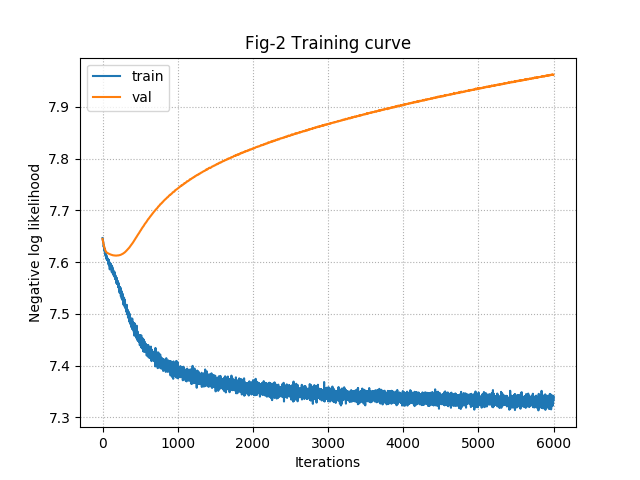

In [11]:
plt.plot(list(np.arange(0, len(train_log))), train_log, label='train')
plt.plot(list(np.arange(0, len(val_log))), val_log, label='val')
plt.legend()
plt.title("Fig-2 Training curve")
plt.xlabel("Iterations")
plt.ylabel("Negative log likelihood")
plt.grid(linestyle=':')

<IPython.core.display.Javascript object>


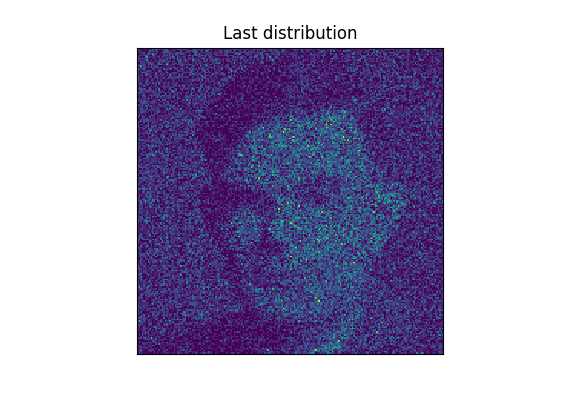

Test NLL 7.961 (bits per dim)


In [12]:
load_checkpoint('./checkpoints/MADE/last.pth.tar', net)
dist_last = net.get_distribution()
plt.imshow(dist_last)
plt.xticks([])
plt.yticks([])
plt.title("Last distribution")

x_test_long = X_test.cuda().long()
x_test = one_hot_cat(x_test_long) 
p_test = net(x_test)
nll_test = get_mean_NLL(p_test, x_test_long).detach() / (2 * np.log(2.0))
print("Test NLL {:.3f} (bits per dim)".format(nll_test))

<IPython.core.display.Javascript object>


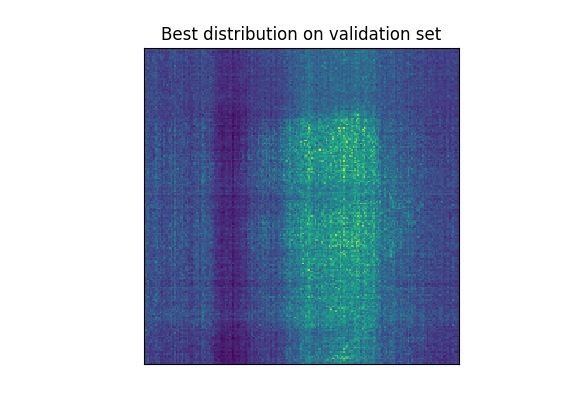

Test NLL 7.610 (bits per dim)


In [14]:
load_checkpoint('./checkpoints/MADE/best.pth.tar', net)
dist_best = net.get_distribution()
plt.imshow(dist_best)
plt.xticks([])
plt.yticks([])
x_test_long = X_test.cuda().long()
x_test = one_hot_cat(x_test_long) 
p_test = net(x_test)
plt.title("Best distribution on validation set")
nll_test = get_mean_NLL(p_test, x_test_long).detach() / (2 * np.log(2.0))
print("Test NLL {:.3f} (bits per dim)".format(nll_test))

<IPython.core.display.Javascript object>


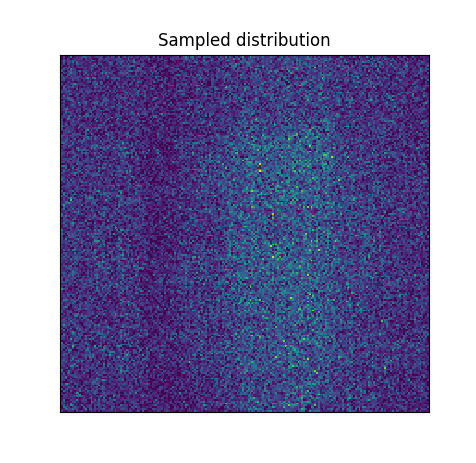

Text(0.5, 1.0, 'Sampled distribution')

In [16]:
# sample from estimated distribution
samples_made = sample2d(dist_best / np.sum(dist_best), 100000)
_, _, _, fig = plt.hist2d(samples_made[:, 1], samples_made[:, 0], bins=[200, 200])
ax = fig.axes
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
plt.title("Sampled distribution")

### Remarks
In 2D cases, MADE is actually the same as the MLP model.